### Nutri-score Project - Decision Modeling - Master BDMA 2025/2026

**Notebook 2: ELECTRE TRI Sorting Model**

This notebook implements the MR-SORT Multi-Criteria Decision Analysis method, which is a simplified version of ELECTRE-TRI, to classify food products into nutritional categories (A', B', C', D', E'). This serves as an alternative model to the standard Nutri-Score algorithm.

**Objectives:**
1.  **Define Model Parameters**:
    *   Criteria: 7 Nutri-Score components + Green-Score.
    *   Weights: Justified quantification of relative importance.
    *   Limiting Profiles: 6 profiles defining the boundaries between classes.
2.  **Implement Sorting Procedures**:
    *   Pessimistic Sorting: Conservative assignment (pseudo-conjunctive).
    *   Optimistic Sorting: Optimistic assignment (pseudo-disjunctive).
3.  **Model Application**: Apply the sorting models to the food database.
4.  **Comparison**: Analyze agreement/disagreement between ELECTRE TRI assignments and official Nutri-Score labels using confusion matrices.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.isotonic import IsotonicRegression
from scipy.stats import spearmanr
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and validate database
df = model_utils.load_food_database('data/food_database.xlsx')
model_utils.validate_database(df)

Database loaded: 353 products

=== DATABASE VALIDATION ===
Total products: 353
✓ Database size requirement met

Nutri-Score Distribution:
  ✓ Class A: 71 (20.11%)
  ✓ Class B: 70 (19.83%)
  ✓ Class C: 84 (23.8%)
  ✓ Class D: 59 (16.71%)
  ✓ Class E: 69 (19.55%)

Green-Score Distribution:
  ✓ Class A: 92 (26.06%)
  ✓ Class B: 102 (28.9%)
  ✓ Class C: 56 (15.86%)
  ✓ Class D: 49 (13.88%)
  ✓ Class E: 54 (15.3%)


#### MR Sort Algorithm

In [4]:
def MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions):
    weight_sum = 0
    for criterion, weight in weights.items():
        a_val = alternative[criterion]
        p_val = profile[criterion]
        if criteria_directions[criterion] == 'max':
            if a_val >= p_val:
                weight_sum += weight
        else:  # min
            if a_val <= p_val:
                weight_sum += weight
    return weight_sum >= lambda_threshold

In [5]:
# Classify alternative into categories using MR-Sort
# This function implements both pessimistic and optimistic classification methods

def MRSort_classify_pessimistic(alternative, profiles, weights, lambda_threshold, criteria_directions):
    """Pessimistic: decrease k from r-1 until first k where a S π_k (ETRI-B-pc)"""
    for k in range(len(profiles) - 1, -1, -1):
        profile = profiles.iloc[k]
        if MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions):
            return k + 1
    return 0  # Worst category (E)

def MRSort_classify_optimistic(alternative, profiles, weights, lambda_threshold, criteria_directions):
    """Optimistic: increase k from 1 until first k where π_k P a (ETRI-B-pd)"""
    for k in range(len(profiles)):
        profile = profiles.iloc[k]
        # π_k P a: π_k S a AND NOT a S π_k
        profile_outranks_a = MRSort_assign(profile, alternative, weights, lambda_threshold, criteria_directions)
        a_outranks_profile = MRSort_assign(alternative, profile, weights, lambda_threshold, criteria_directions)
        if profile_outranks_a and not a_outranks_profile:
            return k
    return len(profiles)  # Best category (A)

def MRSort_classify(alternative, profiles, weights, lambda_threshold, criteria_directions, method='pessimistic'):
    if method == 'pessimistic':
        return MRSort_classify_pessimistic(alternative, profiles, weights, lambda_threshold, criteria_directions)
    return MRSort_classify_optimistic(alternative, profiles, weights, lambda_threshold, criteria_directions)

In [6]:
# Evaluate model accuracy on reference assignments

def evaluate_mrsort_model(df, profiles, weights, lambda_threshold, criteria_cols, criteria_directions, assignment_col='nutri_score_label'):
    label_to_idx = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}
    df = df.copy()
    df['target_category'] = df[assignment_col].map(label_to_idx)
    
    correct = 0
    criteria_directions_dict = criteria_directions
    
    for idx, row in df.iterrows():
        alternative = row[criteria_cols].to_dict()
        predicted = MRSort_classify(alternative, profiles, weights, lambda_threshold, criteria_directions_dict)
        true_category = label_to_idx.get(row[assignment_col], 0)
        if predicted == true_category:
            correct += 1
    
    return correct / len(df)

In [7]:
def create_profiles_quantile_mrsort(df, criteria_cols, n_categories=5, quantiles=[0.20, 0.40, 0.60, 0.80]):
    """Create 4 limiting profiles for 5 categories using quantiles"""
    profiles = []
    for q in quantiles:
        profile = {col: df[col].quantile(q) for col in criteria_cols}
        profiles.append(profile)
    profiles_df = pd.DataFrame(profiles)
    profiles_df.index = ['π2(E/D)', 'π3(D/C)', 'π4(C/B)', 'π5(B/A)']
    return profiles_df

In [8]:
def mrsort_confusion_analysis(df, weights, profiles, lambda_threshold=0.6, method='pessimistic', quantile=[0.20, 0.40, 0.60, 0.80]):
    labels = ['E', 'D', 'C', 'B', 'A']    
    criteria_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 
                    'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
    
    # Filter to available columns only
    available_cols = [col for col in criteria_cols if col in df.columns]
    print(f"✅ Using {len(available_cols)}/{len(criteria_cols)} criteria: {available_cols}")

    if weights is None:
        weights = {col: 1.0/7 for col in criteria_cols}
    if profiles is None:
        profiles = create_profiles_quantile_mrsort(df, criteria_cols, quantiles=quantile)
    
    criteria_directions = {
        'energy_100g': 'min', 'saturated_fat_100g': 'min', 'sugars_100g': 'min',
        'salt_100g': 'min', 'proteins_100g': 'max', 'fiber_100g': 'max', 
        'fvl_percent': 'max', 'green_score_value': 'max' 
    }
    
    # Generate predictions
    y_true = df['nutri_score_label'].values
    y_pred = []
    
    for idx, row in df.iterrows():
        alt = row[available_cols].to_dict()
        pred_idx = MRSort_classify(alt, profiles, weights, lambda_threshold, 
                                 criteria_directions, method)
        y_pred.append(labels[pred_idx])
    
    # METRICS
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    cm = confusion_matrix(y_true, y_pred, labels=['E','D','C','B','A'])
    
    print(f"\n📊 MR-Sort {method.title()} Results")
    print(f"Overall Accuracy: {accuracy:.1%} ({accuracy*len(df):.0f}/{len(df)})")
    
    # Compute percentages (row-normalized)
    percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Dual annotation: count + %
    labels = np.asarray([[f'{c}\n({p:.0f}%)' for c, p in zip(row, perc_row)] 
                        for row, perc_row in zip(cm, percentages)])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['E\'','D\'','C\'','B\'','A\''],
                yticklabels=['E','D','C','B','A'],
                cbar_kws={'label': 'Count'},
                annot_kws={"size": 14, "weight": "bold"})

    plt.title(f'MR-Sort {method.title()} Confusion Matrix\n'
              f'Accuracy: {accuracy:.1%} | λ={lambda_threshold} | {len(available_cols)} criteria')
    plt.ylabel('True Nutri-Score'); plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
    # PER-CATEGORY ACCURACY
    print("\nPer-category accuracy:")
    for label in ['E', 'D', 'C', 'B', 'A']:
        mask = y_true == label
        cat_acc = (np.array(y_pred)[mask] == label).mean()
        print(f"  {label}: {cat_acc:.1%} ({mask.sum()} samples)")
    
    print("\n" + classification_report(y_true, y_pred))
    
    return {'accuracy': accuracy, 'y_true': y_true, 'y_pred': y_pred, 'cm': cm}

#### Baseline: Profiles based on Quintiles + Equal Weights (1/8)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 43.1% (152/353)


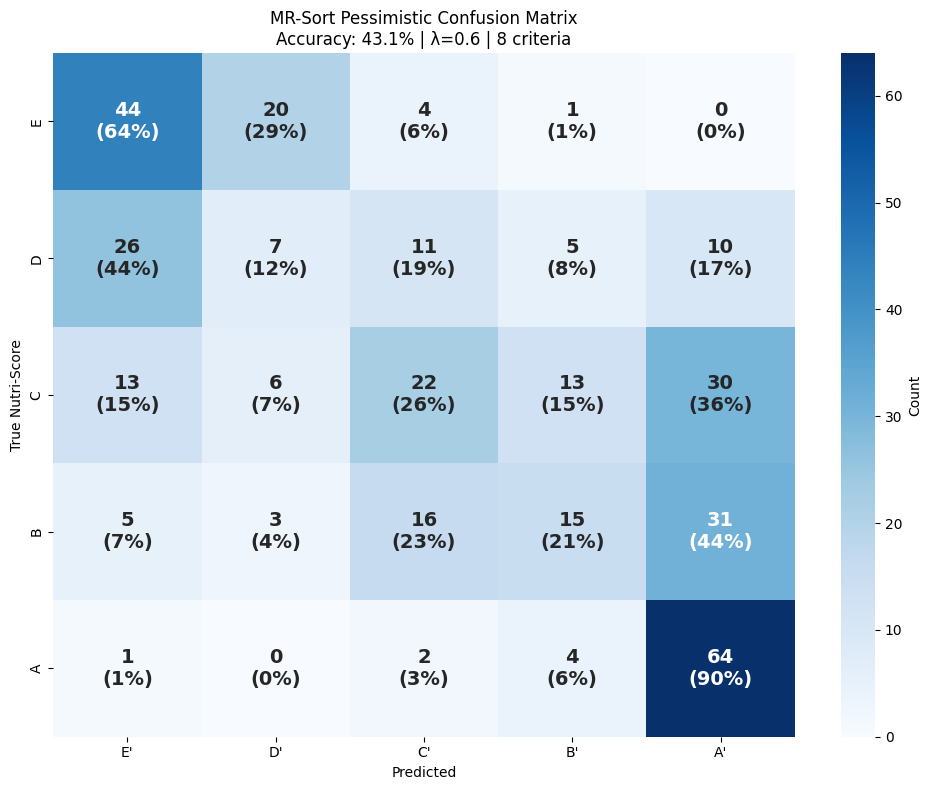


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 11.9% (59 samples)
  C: 26.2% (84 samples)
  B: 21.4% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.90      0.62        71
           B       0.39      0.21      0.28        70
           C       0.40      0.26      0.32        84
           D       0.19      0.12      0.15        59
           E       0.49      0.64      0.56        69

    accuracy                           0.43       353
   macro avg       0.39      0.43      0.38       353
weighted avg       0.40      0.43      0.39       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 43.1% (152/353)


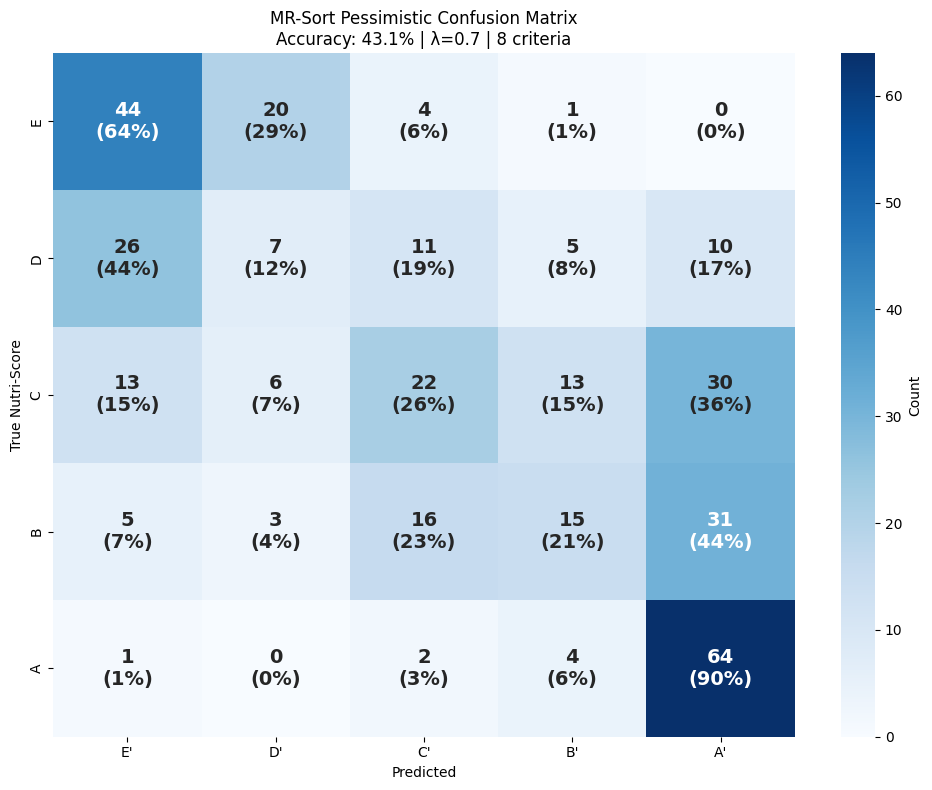


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 11.9% (59 samples)
  C: 26.2% (84 samples)
  B: 21.4% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.90      0.62        71
           B       0.39      0.21      0.28        70
           C       0.40      0.26      0.32        84
           D       0.19      0.12      0.15        59
           E       0.49      0.64      0.56        69

    accuracy                           0.43       353
   macro avg       0.39      0.43      0.38       353
weighted avg       0.40      0.43      0.39       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


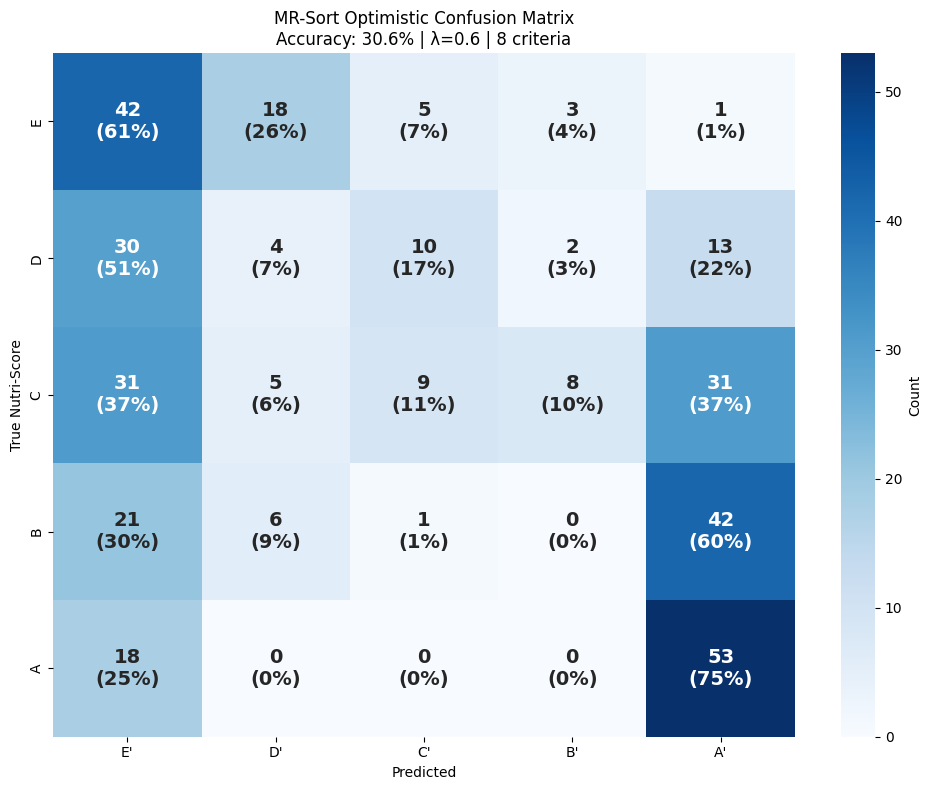


Per-category accuracy:
  E: 60.9% (69 samples)
  D: 6.8% (59 samples)
  C: 10.7% (84 samples)
  B: 0.0% (70 samples)
  A: 74.6% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.75      0.50        71
           B       0.00      0.00      0.00        70
           C       0.36      0.11      0.17        84
           D       0.12      0.07      0.09        59
           E       0.30      0.61      0.40        69

    accuracy                           0.31       353
   macro avg       0.23      0.31      0.23       353
weighted avg       0.24      0.31      0.23       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


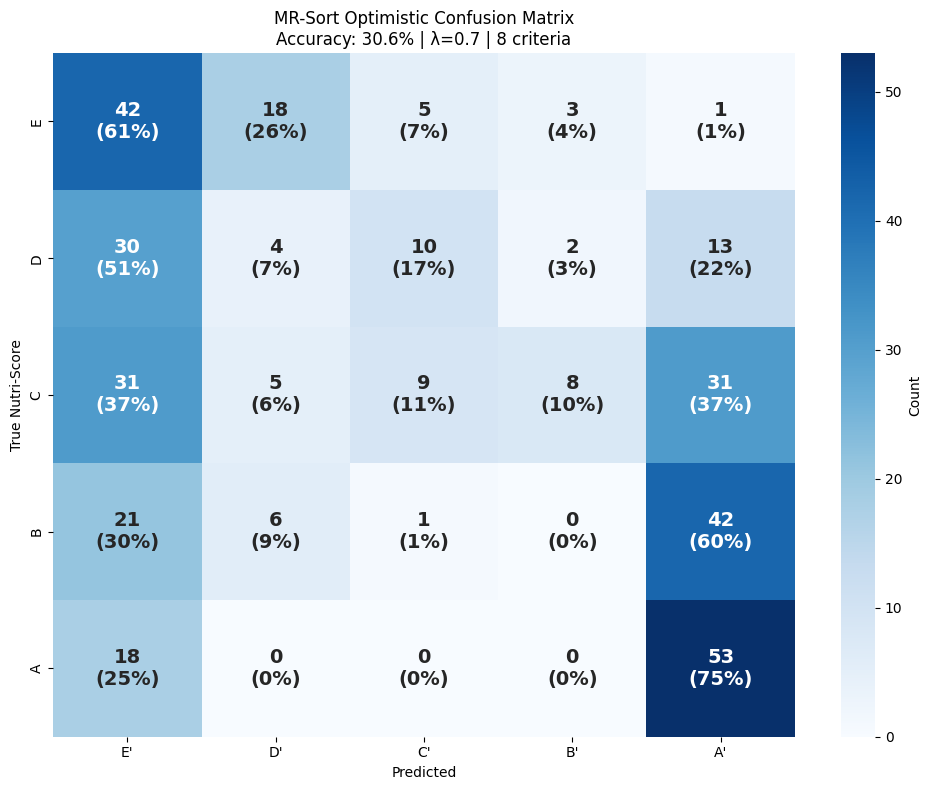


Per-category accuracy:
  E: 60.9% (69 samples)
  D: 6.8% (59 samples)
  C: 10.7% (84 samples)
  B: 0.0% (70 samples)
  A: 74.6% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.75      0.50        71
           B       0.00      0.00      0.00        70
           C       0.36      0.11      0.17        84
           D       0.12      0.07      0.09        59
           E       0.30      0.61      0.40        69

    accuracy                           0.31       353
   macro avg       0.23      0.31      0.23       353
weighted avg       0.24      0.31      0.23       353



In [9]:
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 38.2% (135/353)


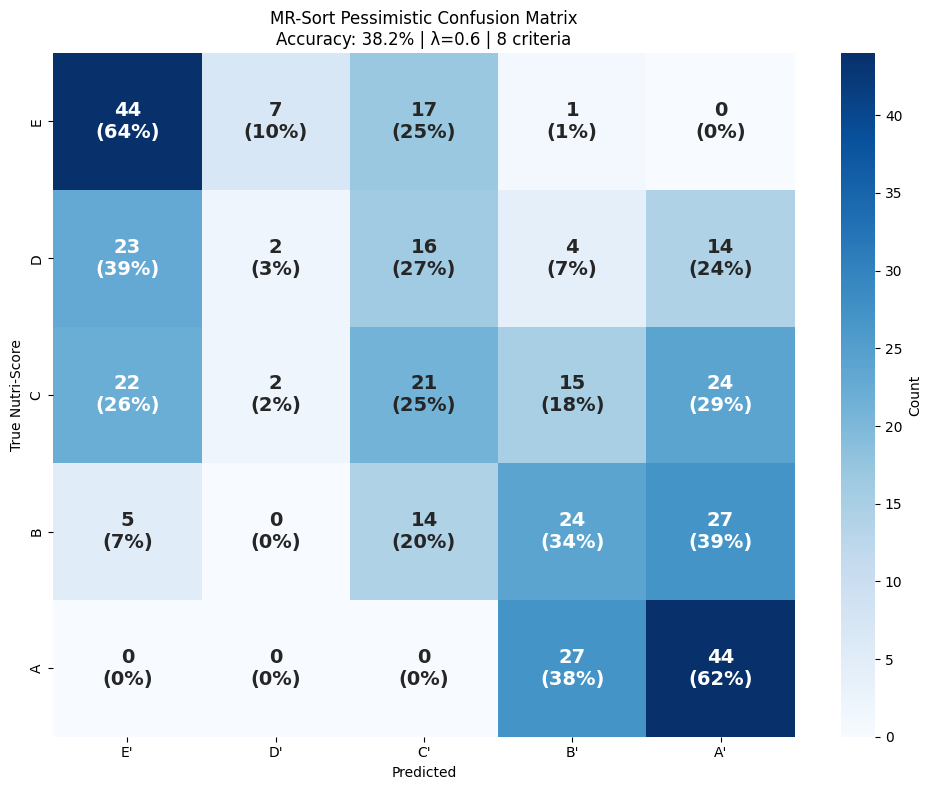


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 3.4% (59 samples)
  C: 25.0% (84 samples)
  B: 34.3% (70 samples)
  A: 62.0% (71 samples)

              precision    recall  f1-score   support

           A       0.40      0.62      0.49        71
           B       0.34      0.34      0.34        70
           C       0.31      0.25      0.28        84
           D       0.18      0.03      0.06        59
           E       0.47      0.64      0.54        69

    accuracy                           0.38       353
   macro avg       0.34      0.38      0.34       353
weighted avg       0.34      0.38      0.35       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 38.2% (135/353)


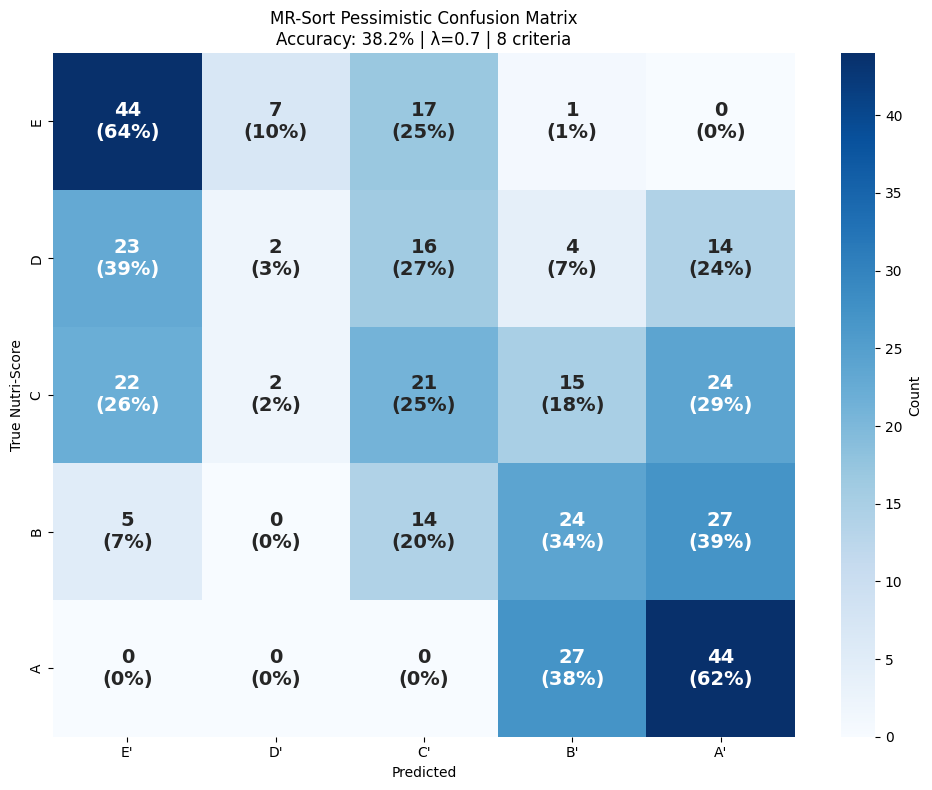


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 3.4% (59 samples)
  C: 25.0% (84 samples)
  B: 34.3% (70 samples)
  A: 62.0% (71 samples)

              precision    recall  f1-score   support

           A       0.40      0.62      0.49        71
           B       0.34      0.34      0.34        70
           C       0.31      0.25      0.28        84
           D       0.18      0.03      0.06        59
           E       0.47      0.64      0.54        69

    accuracy                           0.38       353
   macro avg       0.34      0.38      0.34       353
weighted avg       0.34      0.38      0.35       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 32.3% (114/353)


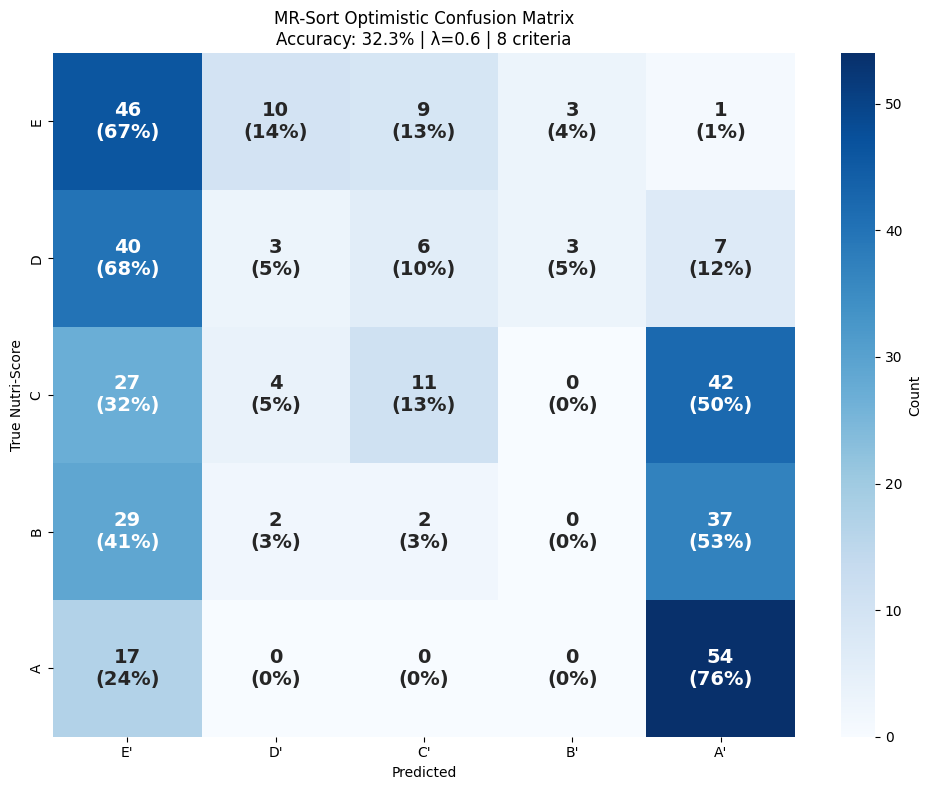


Per-category accuracy:
  E: 66.7% (69 samples)
  D: 5.1% (59 samples)
  C: 13.1% (84 samples)
  B: 0.0% (70 samples)
  A: 76.1% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.76      0.51        71
           B       0.00      0.00      0.00        70
           C       0.39      0.13      0.20        84
           D       0.16      0.05      0.08        59
           E       0.29      0.67      0.40        69

    accuracy                           0.32       353
   macro avg       0.24      0.32      0.24       353
weighted avg       0.25      0.32      0.24       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 32.3% (114/353)


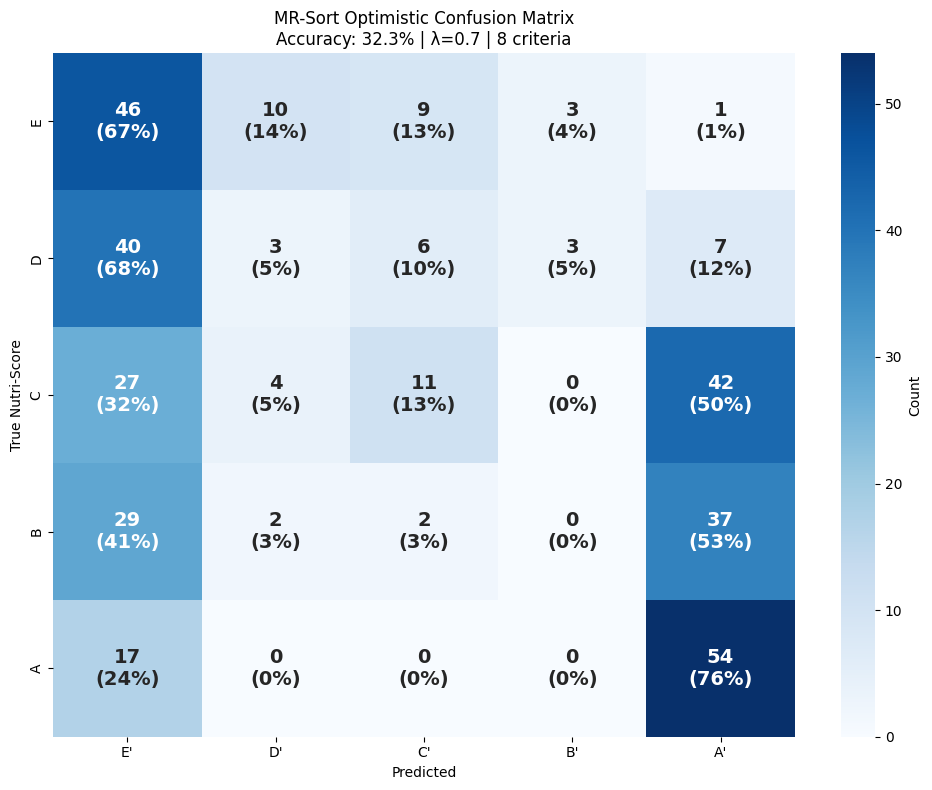


Per-category accuracy:
  E: 66.7% (69 samples)
  D: 5.1% (59 samples)
  C: 13.1% (84 samples)
  B: 0.0% (70 samples)
  A: 76.1% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.76      0.51        71
           B       0.00      0.00      0.00        70
           C       0.39      0.13      0.20        84
           D       0.16      0.05      0.08        59
           E       0.29      0.67      0.40        69

    accuracy                           0.32       353
   macro avg       0.24      0.32      0.24       353
weighted avg       0.25      0.32      0.24       353



In [10]:
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', quantile=[0.1, 0.3, 0.6, 0.9], lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='pessimistic', quantile=[0.1, 0.3, 0.6, 0.9],lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', quantile=[0.1, 0.3, 0.6, 0.9],lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, None, method='optimistic', quantile=[0.1, 0.3, 0.6, 0.9],lambda_threshold=0.7)

#### Trial 1: Profiles based on Distribution + Correlation-based Weights

For the first trial, the profiles were set based on the distribution of the nutri-score values. This assumes that the distribution of scores in the original data also represents the actual distribution of scores.

In [11]:
criteria_names = [
    'energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 
    'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value'
]

# -1 = Minimize (Low is better for Grade A), 1 = Maximize (High is better for Grade A)
directions = [-1, -1, -1, -1, 1, 1, 1, 1] 

# Map labels to numeric values (0=E, 4=A)
grade_map = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}

# =============================================================================
# 1. ANALYZE DISTRIBUTION
# =============================================================================

# Ensure we have the target column formatted correctly
if 'nutri_score_label' not in df.columns:
    raise ValueError("DataFrame missing 'nutri_score_label' column")

y = df['nutri_score_label'].astype(str).str.upper().str.strip().map(grade_map).fillna(0).astype(int).values
X = df[criteria_names].apply(pd.to_numeric, errors='coerce').fillna(0).values

# Calculate Counts and Percentages
total_samples = len(y)
inv_map = {0:'E', 1:'D', 2:'C', 3:'B', 4:'A'}

print("\n" + "="*60)
print("1. DATA DISTRIBUTION (CLASS SIZES)")
print("="*60)
print(f"{'Class':<6} | {'Count':<8} | {'Percentage':<12} | {'Cumulative % (Boundary)':<25}")
print("-" * 60)

current_cumulative = 0
cumulative_pcts = []

# Iterate from E (0) to B (3) to find the "Top" boundary of each class
# We don't need A's boundary because A is everything above B.
for k in range(4): # 0, 1, 2, 3
    count = np.sum(y == k)
    pct = (count / total_samples) * 100
    current_cumulative += pct
    
    # Store for threshold calculation
    # Clamp to avoid 0/100 issues
    safe_cumulative = np.clip(current_cumulative, 1, 99)
    cumulative_pcts.append(safe_cumulative)
    
    print(f"{inv_map[k]:<6} | {count:<8} | {pct:>9.2f}%  | {current_cumulative:>21.2f}%")

# Print Class A separately (it has no upper boundary in this logic)
count_a = np.sum(y == 4)
pct_a = (count_a / total_samples) * 100
print(f"{'A':<6} | {count_a:<8} | {pct_a:>9.2f}%  | {'(Top Class)':>21}")
print("-" * 60)
print(f"TOTAL  | {total_samples:<8} | 100.00%")


1. DATA DISTRIBUTION (CLASS SIZES)
Class  | Count    | Percentage   | Cumulative % (Boundary)  
------------------------------------------------------------
E      | 69       |     19.55%  |                 19.55%
D      | 59       |     16.71%  |                 36.26%
C      | 84       |     23.80%  |                 60.06%
B      | 70       |     19.83%  |                 79.89%
A      | 71       |     20.11%  |           (Top Class)
------------------------------------------------------------
TOTAL  | 353      | 100.00%


In [12]:
# =============================================================================
# 2. CALCULATE AND PRINT THRESHOLDS
# =============================================================================

print("\n" + "="*60)
print("2. CALCULATED LIMITING PROFILES (THRESHOLDS)")
print("="*60)
print("These are the specific values separating the classes based on the data.\n")

# Create a DataFrame to hold the thresholds
boundary_names = ["D/E (Limit 1)", "C/D (Limit 2)", "B/C (Limit 3)", "A/B (Limit 4)"]
profile_distribution = pd.DataFrame(index=boundary_names, columns=criteria_names)

for i, col in enumerate(criteria_names):
    direction = directions[i]
    
    for k in range(4): # Boundaries for E|D, D|C, C|B, B|A
        percentile = cumulative_pcts[k]
        
        if direction == -1:
            # MINIMIZE (Energy, Sugar): 
            # Class E (Worst) is at the TOP (High values).
            # Class A (Best) is at the BOTTOM (Low values).
            # So the boundary "above" E is actually at the (100 - p) percentile.
            val = np.percentile(X[:, i], 100 - percentile)
        else:
            # MAXIMIZE (Protein, Fiber):
            # Class E (Worst) is at the BOTTOM (Low values).
            # The boundary "above" E is at the p percentile.
            val = np.percentile(X[:, i], percentile)
            
        profile_distribution.iloc[k, i] = val

# Formatting for cleaner output
# Transpose so Criteria are rows and Boundaries are columns (usually easier to read)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

formatted_df = profile_distribution.T
print(formatted_df)

print("\nInterpretation:")
print("- A value 'better' than the A/B Limit puts the item in Class A.")
print("- A value 'worse' than the D/E Limit puts the item in Class E.")


2. CALCULATED LIMITING PROFILES (THRESHOLDS)
These are the specific values separating the classes based on the data.

                   D/E (Limit 1) C/D (Limit 2) B/C (Limit 3) A/B (Limit 4)
energy_100g          1648.195467   1392.362606    788.209632    430.195467
saturated_fat_100g           3.0           1.5           0.5           0.1
sugars_100g            26.839093      4.936261      2.568045           0.9
salt_100g                    1.2           0.8       0.47015          0.02
proteins_100g                1.2      4.657365           8.0          12.0
fiber_100g                   0.0           0.5           2.0      4.920113
fvl_percent                  0.0           0.0      2.498635     34.735737
green_score_value           35.0          50.0          70.0          78.0

Interpretation:
- A value 'better' than the A/B Limit puts the item in Class A.
- A value 'worse' than the D/E Limit puts the item in Class E.


The weights are then computed based on the correlation of each criteria to the nutri-score. The magnitude of the correlations among all the values are then normalized so that the weights sum to 1.

In [13]:
def get_weights_dict(df, criteria_cols, target_col):
    print("\n" + "="*60)
    print("3. CALCULATED WEIGHTS")
    print("="*60)
    print("These are the weights based on the weighted correlation between criteria and nutri-score.")

    # 1. Ensure target is numeric (Map A-E to 4-0 if needed, or 0-4)
    # Assuming the target is already numeric here based on your previous code
    grade_map = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}
    y = df['nutri_score_label'].map(grade_map).values
    
    correlations = []
    
    # 2. Calculate Spearman Correlation for each criterion
    for col in criteria_cols:
        x = df[col].values
        # We use absolute value because we only care about the strength of the relationship
        corr, _ = spearmanr(x, y)
        correlations.append(abs(corr))
        
    # 3. Normalize correlations so they sum to 1.0
    total_corr = np.sum(correlations)
    
    # Handle edge case if total is 0 (rare)
    if total_corr == 0:
        normalized_weights = np.ones(len(criteria_cols)) / len(criteria_cols)
    else:
        normalized_weights = np.array(correlations) / total_corr
        
    # 4. Create the specific dictionary format
    weights_dict = {
        col: np.float64(weight) 
        for col, weight in zip(criteria_cols, normalized_weights)
    }
    
    return weights_dict

criteria = [
    'energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 
    'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value'
]

weight_correlation = get_weights_dict(df, criteria, 'nutri_score_label')
weight_correlation


3. CALCULATED WEIGHTS
These are the weights based on the weighted correlation between criteria and nutri-score.


{'energy_100g': np.float64(0.19631013567521824),
 'saturated_fat_100g': np.float64(0.1303235709737621),
 'sugars_100g': np.float64(0.18913090227627719),
 'salt_100g': np.float64(0.0982140038250653),
 'proteins_100g': np.float64(0.10283884971850943),
 'fiber_100g': np.float64(0.11950544268286027),
 'fvl_percent': np.float64(0.06531608021934678),
 'green_score_value': np.float64(0.09836101462896073)}

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 40.5% (143/353)


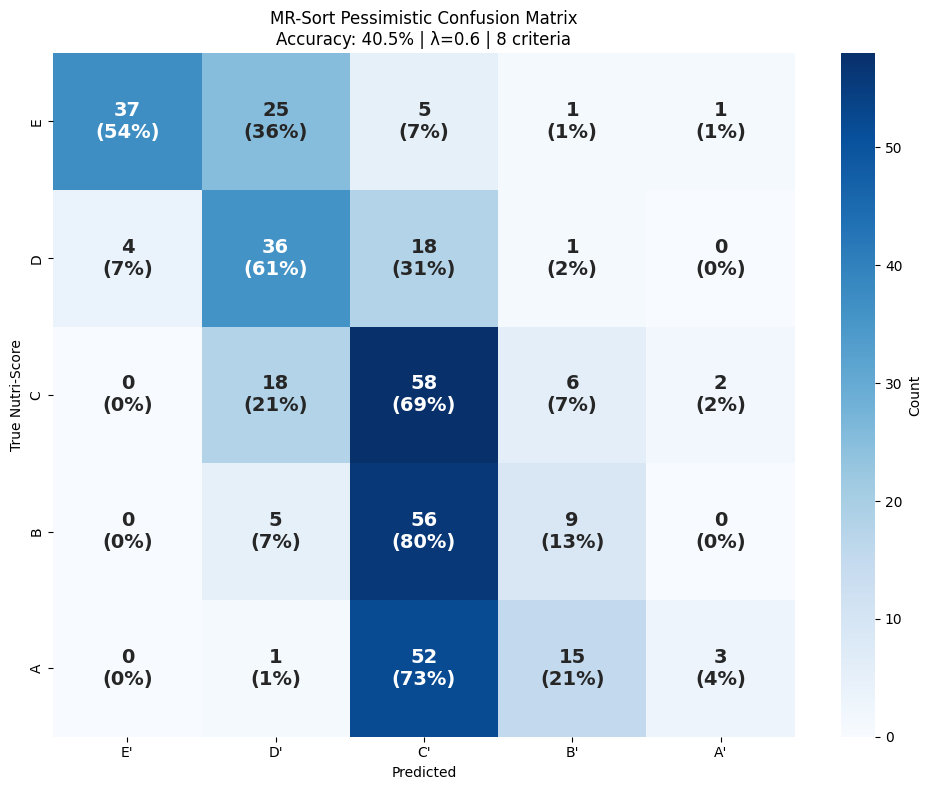


Per-category accuracy:
  E: 53.6% (69 samples)
  D: 61.0% (59 samples)
  C: 69.0% (84 samples)
  B: 12.9% (70 samples)
  A: 4.2% (71 samples)

              precision    recall  f1-score   support

           A       0.50      0.04      0.08        71
           B       0.28      0.13      0.18        70
           C       0.31      0.69      0.42        84
           D       0.42      0.61      0.50        59
           E       0.90      0.54      0.67        69

    accuracy                           0.41       353
   macro avg       0.48      0.40      0.37       353
weighted avg       0.48      0.41      0.37       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 36.3% (128/353)


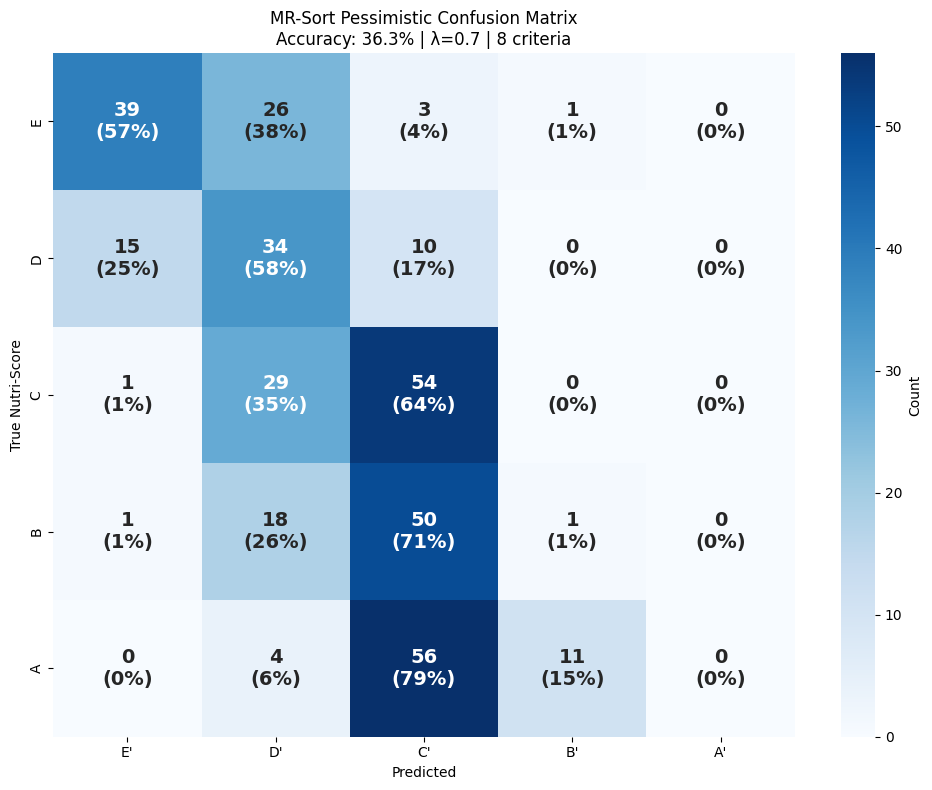


Per-category accuracy:
  E: 56.5% (69 samples)
  D: 57.6% (59 samples)
  C: 64.3% (84 samples)
  B: 1.4% (70 samples)
  A: 0.0% (71 samples)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        71
           B       0.08      0.01      0.02        70
           C       0.31      0.64      0.42        84
           D       0.31      0.58      0.40        59
           E       0.70      0.57      0.62        69

    accuracy                           0.36       353
   macro avg       0.28      0.36      0.29       353
weighted avg       0.28      0.36      0.29       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 34.3% (121/353)


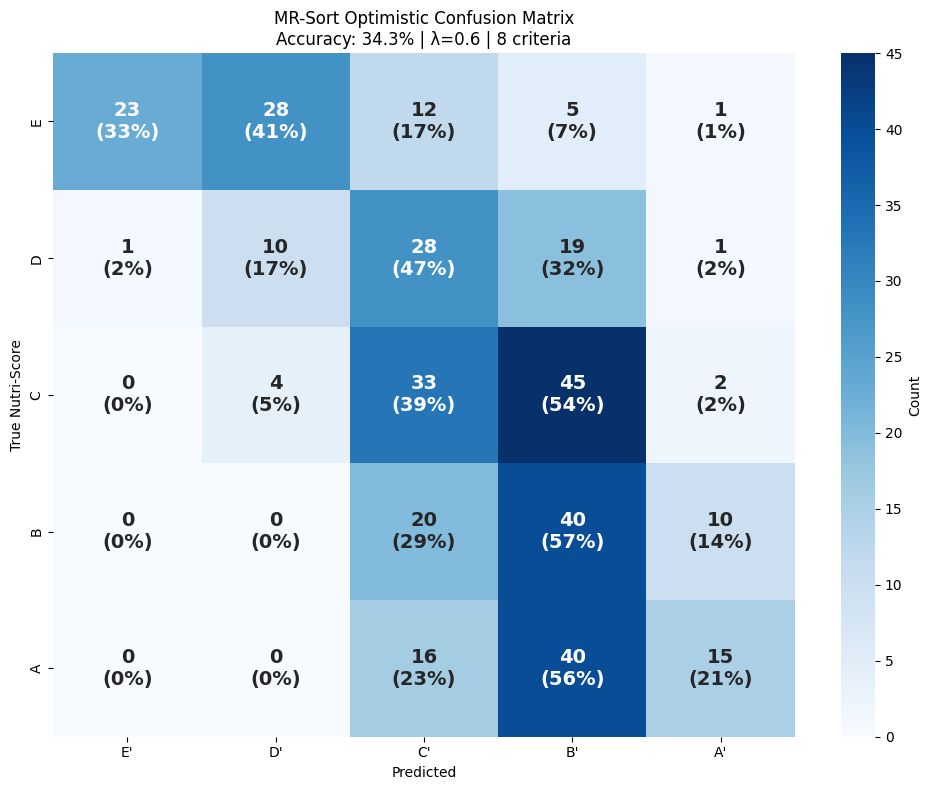


Per-category accuracy:
  E: 33.3% (69 samples)
  D: 16.9% (59 samples)
  C: 39.3% (84 samples)
  B: 57.1% (70 samples)
  A: 21.1% (71 samples)

              precision    recall  f1-score   support

           A       0.52      0.21      0.30        71
           B       0.27      0.57      0.37        70
           C       0.30      0.39      0.34        84
           D       0.24      0.17      0.20        59
           E       0.96      0.33      0.49        69

    accuracy                           0.34       353
   macro avg       0.46      0.34      0.34       353
weighted avg       0.46      0.34      0.34       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 26.1% (92/353)


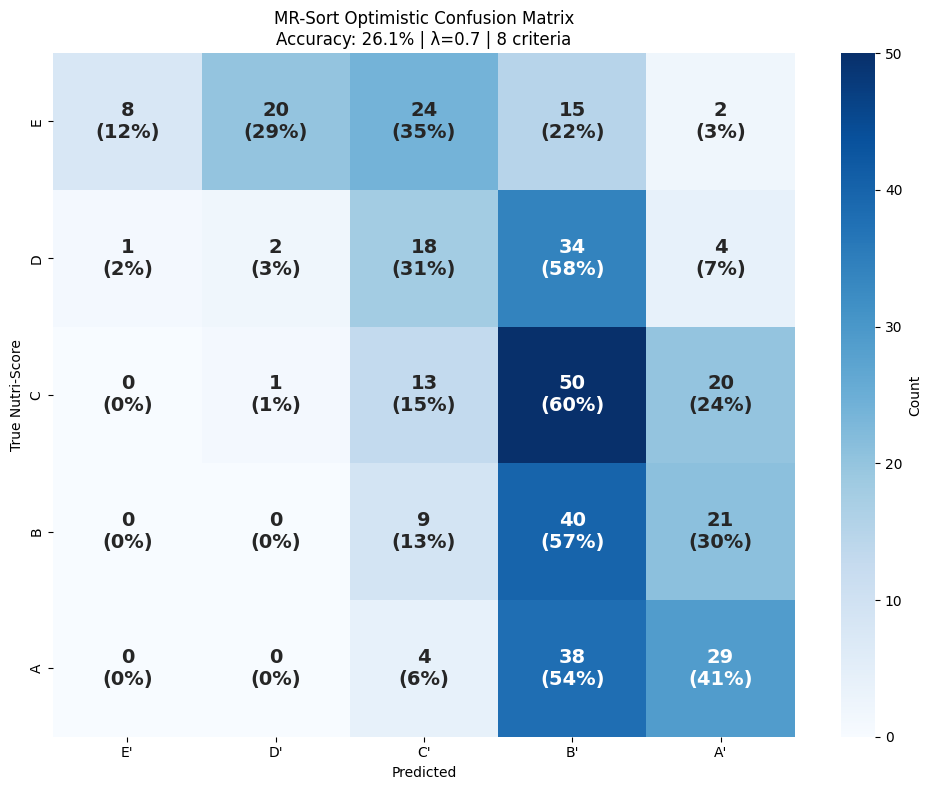


Per-category accuracy:
  E: 11.6% (69 samples)
  D: 3.4% (59 samples)
  C: 15.5% (84 samples)
  B: 57.1% (70 samples)
  A: 40.8% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.41      0.39        71
           B       0.23      0.57      0.32        70
           C       0.19      0.15      0.17        84
           D       0.09      0.03      0.05        59
           E       0.89      0.12      0.21        69

    accuracy                           0.26       353
   macro avg       0.35      0.26      0.23       353
weighted avg       0.36      0.26      0.23       353



In [14]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_distribution, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_distribution, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_distribution, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_distribution, method='optimistic', lambda_threshold=0.7)

#### Weights based on Differential Optimization + Profiles Based on Distribution

In [15]:
def optimize_weights_mrsort(df, profiles, lambda_threshold, criteria_cols, criteria_directions, method='pessimistic'):
    """
    Optimize weights using Differential Evolution to maximize accuracy.
    """
    target_labels = df['nutri_score_label'].values
    grade_map = {'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4}
    y_true = np.array([grade_map[l] for l in target_labels])
    
    if profiles is None:
        profiles = create_profiles_quantile_mrsort(df, criteria_cols)

    # Pre-convert alternatives to avoid pandas overhead in loop
    alternatives = df[criteria_cols].to_dict('records')
    
    def objective_function(w_array):
        # 1. Normalize weights so they sum to 1
        # Avoid division by zero
        if np.sum(w_array) == 0: 
            return 1.0 
        normalized_w = w_array / np.sum(w_array)
        
        weights_dict = {col: normalized_w[i] for i, col in enumerate(criteria_cols)}
        
        # 2. Run Classification
        correct = 0
        for i, alt in enumerate(alternatives):
            pred_idx = MRSort_classify(
                alt, profiles, weights_dict, lambda_threshold, criteria_directions, method
            )
            # MRSort_classify returns 0..4 (E..A) which matches our map
            if pred_idx == y_true[i]:
                correct += 1
                
        accuracy = correct / len(y_true)
        return 1 - accuracy  # Minimize error

    # Setup bounds for weights (0 to 1 for each criterion)
    bounds = [(0, 1) for _ in range(len(criteria_cols))]
    
    print("Optimizing weights... (this may take a moment)")
    result = differential_evolution(
        objective_function, 
        bounds, 
        maxiter=10,  # Increase for better results, decrease for speed
        popsize=5,
        seed=42
    )
    
    # Extract best weights
    best_w = result.x / np.sum(result.x)
    best_weights_dict = {col: best_w[i] for i, col in enumerate(criteria_cols)}
    
    print(f"Optimization Complete. Best Accuracy: {1 - result.fun:.2%}")
    return best_weights_dict


criteria_directions = {
        'energy_100g': 'min', 'saturated_fat_100g': 'min', 'sugars_100g': 'min',
        'salt_100g': 'min', 'proteins_100g': 'max', 'fiber_100g': 'max', 
        'fvl_percent': 'max', 'green_score_value': 'max' 
    }

In [16]:
criteria_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 
                    'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

best_weights = optimize_weights_mrsort(df, profile_distribution, 0.7, criteria_cols, criteria_directions)
print(best_weights)

Optimizing weights... (this may take a moment)
Optimization Complete. Best Accuracy: 39.94%
{'energy_100g': np.float64(0.1413630973189331), 'saturated_fat_100g': np.float64(0.12528897660402752), 'sugars_100g': np.float64(0.1414486064924696), 'salt_100g': np.float64(0.12459992185228663), 'proteins_100g': np.float64(0.04607517647718753), 'fiber_100g': np.float64(0.17759239419440348), 'fvl_percent': np.float64(0.19740988224800365), 'green_score_value': np.float64(0.04622194481268843)}


✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 34.0% (120/353)


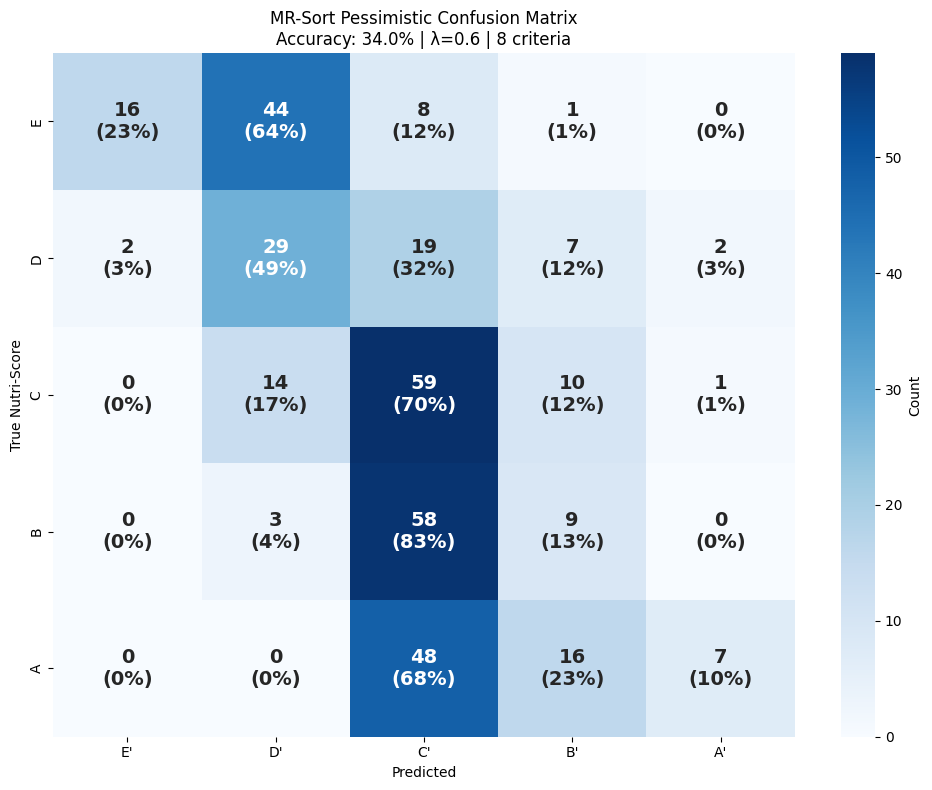


Per-category accuracy:
  E: 23.2% (69 samples)
  D: 49.2% (59 samples)
  C: 70.2% (84 samples)
  B: 12.9% (70 samples)
  A: 9.9% (71 samples)

              precision    recall  f1-score   support

           A       0.70      0.10      0.17        71
           B       0.21      0.13      0.16        70
           C       0.31      0.70      0.43        84
           D       0.32      0.49      0.39        59
           E       0.89      0.23      0.37        69

    accuracy                           0.34       353
   macro avg       0.49      0.33      0.30       353
weighted avg       0.48      0.34      0.31       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 39.9% (141/353)


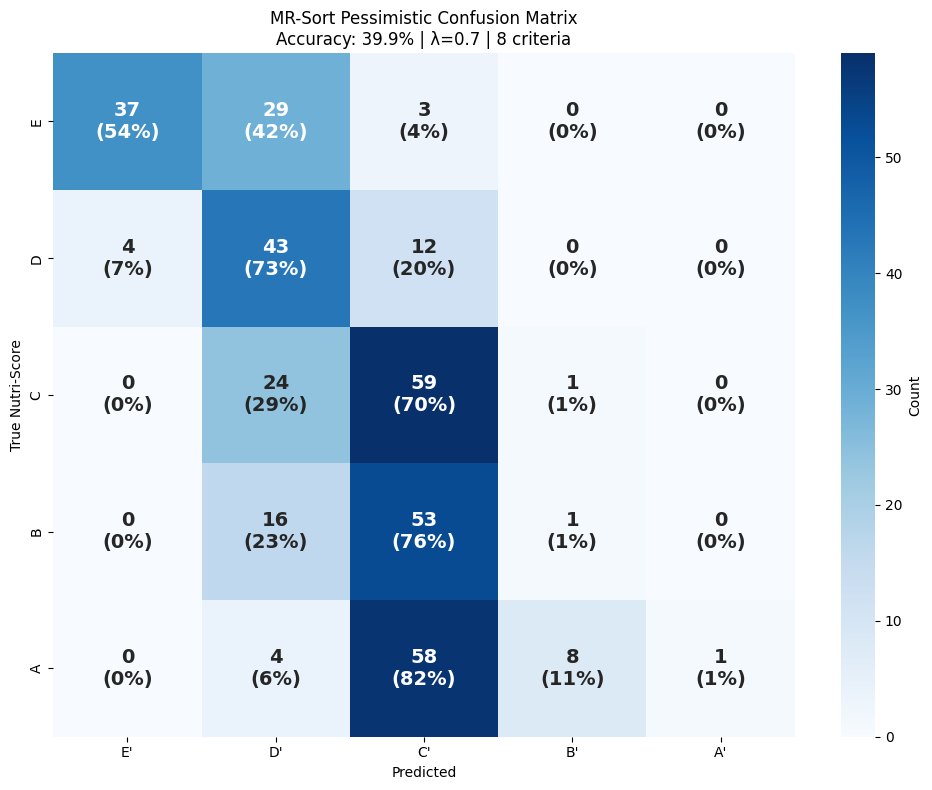


Per-category accuracy:
  E: 53.6% (69 samples)
  D: 72.9% (59 samples)
  C: 70.2% (84 samples)
  B: 1.4% (70 samples)
  A: 1.4% (71 samples)

              precision    recall  f1-score   support

           A       1.00      0.01      0.03        71
           B       0.10      0.01      0.03        70
           C       0.32      0.70      0.44        84
           D       0.37      0.73      0.49        59
           E       0.90      0.54      0.67        69

    accuracy                           0.40       353
   macro avg       0.54      0.40      0.33       353
weighted avg       0.54      0.40      0.33       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 32.3% (114/353)


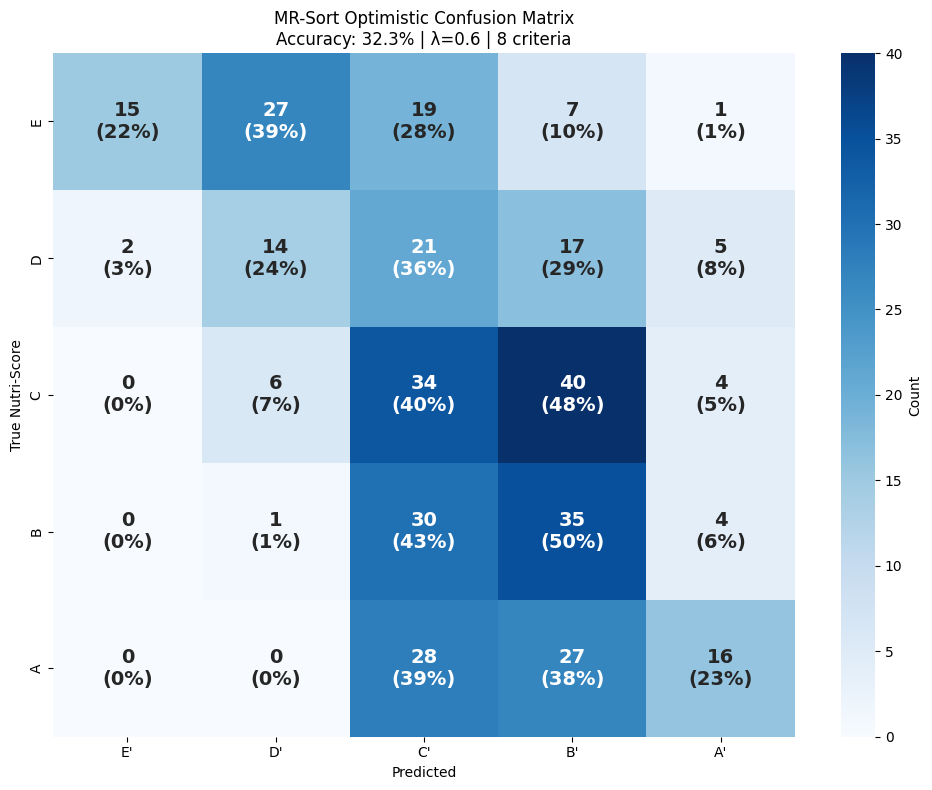


Per-category accuracy:
  E: 21.7% (69 samples)
  D: 23.7% (59 samples)
  C: 40.5% (84 samples)
  B: 50.0% (70 samples)
  A: 22.5% (71 samples)

              precision    recall  f1-score   support

           A       0.53      0.23      0.32        71
           B       0.28      0.50      0.36        70
           C       0.26      0.40      0.31        84
           D       0.29      0.24      0.26        59
           E       0.88      0.22      0.35        69

    accuracy                           0.32       353
   macro avg       0.45      0.32      0.32       353
weighted avg       0.44      0.32      0.32       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


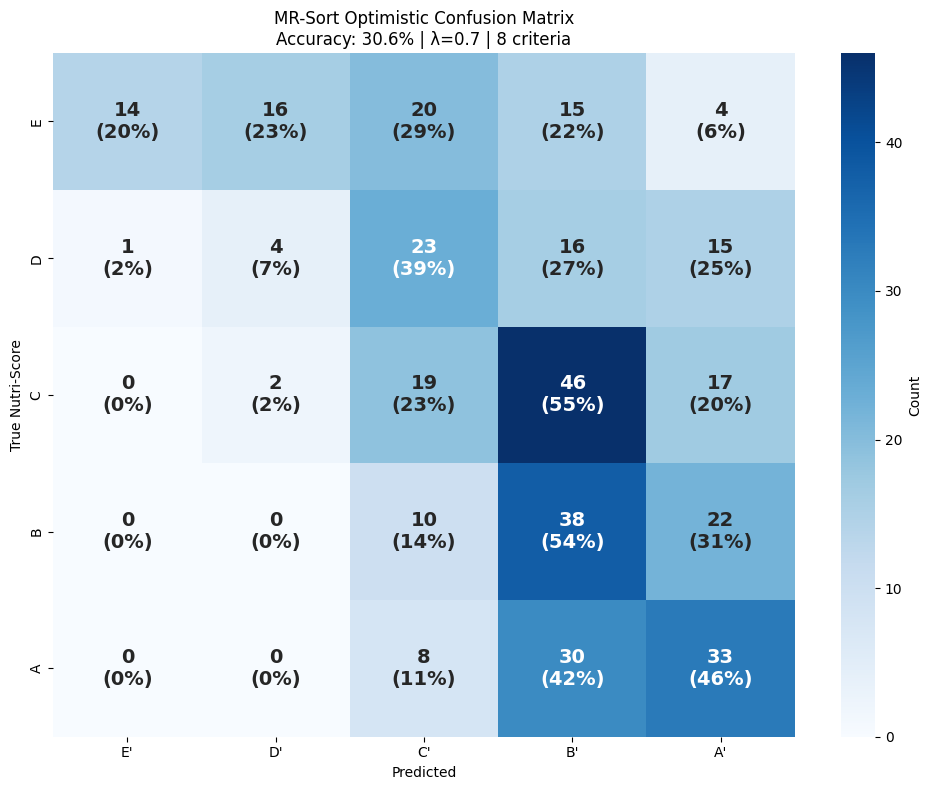


Per-category accuracy:
  E: 20.3% (69 samples)
  D: 6.8% (59 samples)
  C: 22.6% (84 samples)
  B: 54.3% (70 samples)
  A: 46.5% (71 samples)

              precision    recall  f1-score   support

           A       0.36      0.46      0.41        71
           B       0.26      0.54      0.35        70
           C       0.24      0.23      0.23        84
           D       0.18      0.07      0.10        59
           E       0.93      0.20      0.33        69

    accuracy                           0.31       353
   macro avg       0.40      0.30      0.28       353
weighted avg       0.39      0.31      0.29       353



In [17]:
_, _, _, _ = mrsort_confusion_analysis(df, best_weights, profile_distribution, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, best_weights, profile_distribution, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, best_weights, profile_distribution, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, best_weights, profile_distribution, method='optimistic', lambda_threshold=0.7)

In [18]:
weights_equal_profile = optimize_weights_mrsort(df, None, 0.7, criteria_cols, criteria_directions)
print(weights_equal_profile)

Optimizing weights... (this may take a moment)
Optimization Complete. Best Accuracy: 45.89%
{'energy_100g': np.float64(0.22568572137193146), 'saturated_fat_100g': np.float64(0.14951079780324397), 'sugars_100g': np.float64(0.21272408298356976), 'salt_100g': np.float64(0.08874262763817597), 'proteins_100g': np.float64(0.03601759606814513), 'fiber_100g': np.float64(0.14766042914247285), 'fvl_percent': np.float64(0.13832150885073474), 'green_score_value': np.float64(0.0013372361417261752)}


✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 38.5% (136/353)


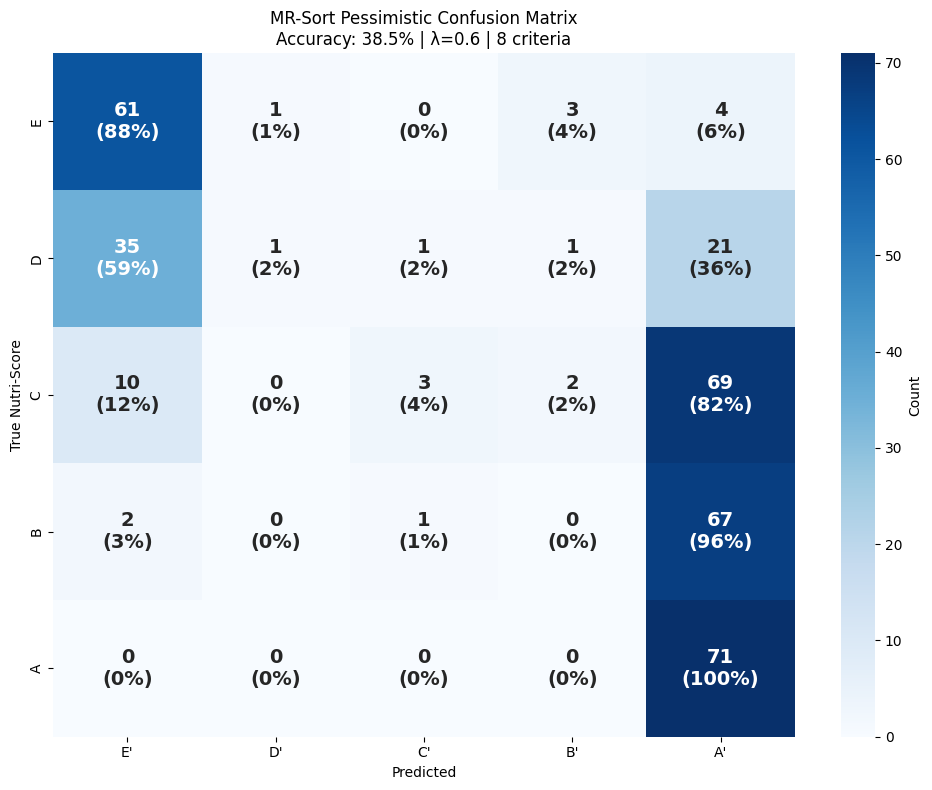


Per-category accuracy:
  E: 88.4% (69 samples)
  D: 1.7% (59 samples)
  C: 3.6% (84 samples)
  B: 0.0% (70 samples)
  A: 100.0% (71 samples)

              precision    recall  f1-score   support

           A       0.31      1.00      0.47        71
           B       0.00      0.00      0.00        70
           C       0.60      0.04      0.07        84
           D       0.50      0.02      0.03        59
           E       0.56      0.88      0.69        69

    accuracy                           0.39       353
   macro avg       0.39      0.39      0.25       353
weighted avg       0.40      0.39      0.25       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 45.9% (162/353)


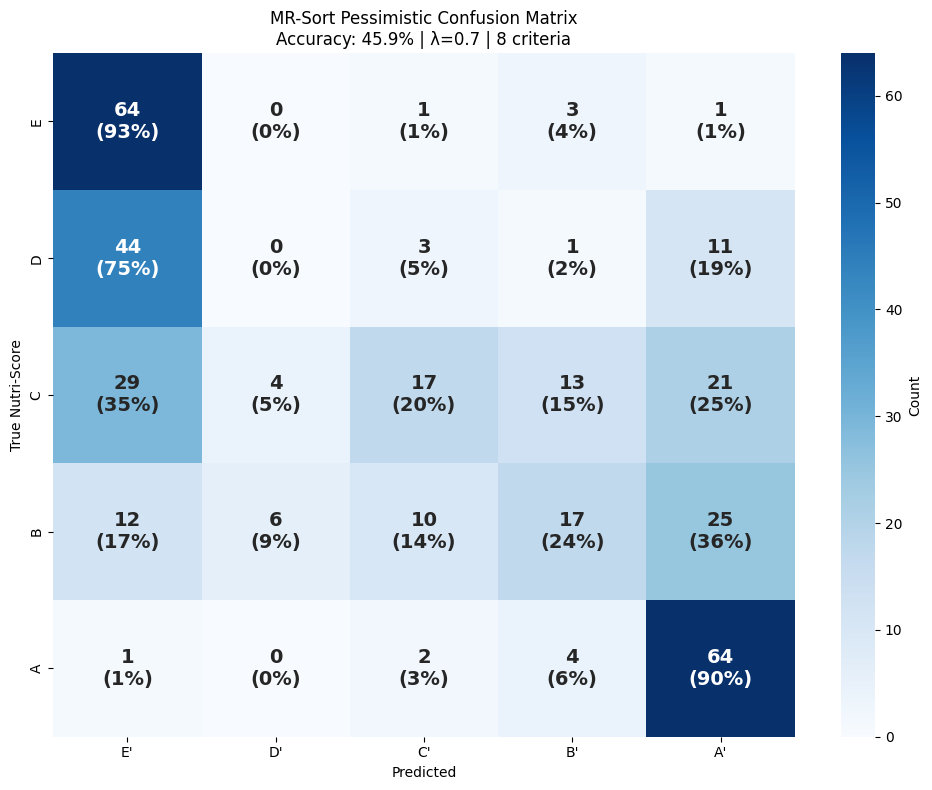


Per-category accuracy:
  E: 92.8% (69 samples)
  D: 0.0% (59 samples)
  C: 20.2% (84 samples)
  B: 24.3% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.52      0.90      0.66        71
           B       0.45      0.24      0.31        70
           C       0.52      0.20      0.29        84
           D       0.00      0.00      0.00        59
           E       0.43      0.93      0.58        69

    accuracy                           0.46       353
   macro avg       0.38      0.45      0.37       353
weighted avg       0.40      0.46      0.38       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 26.9% (95/353)


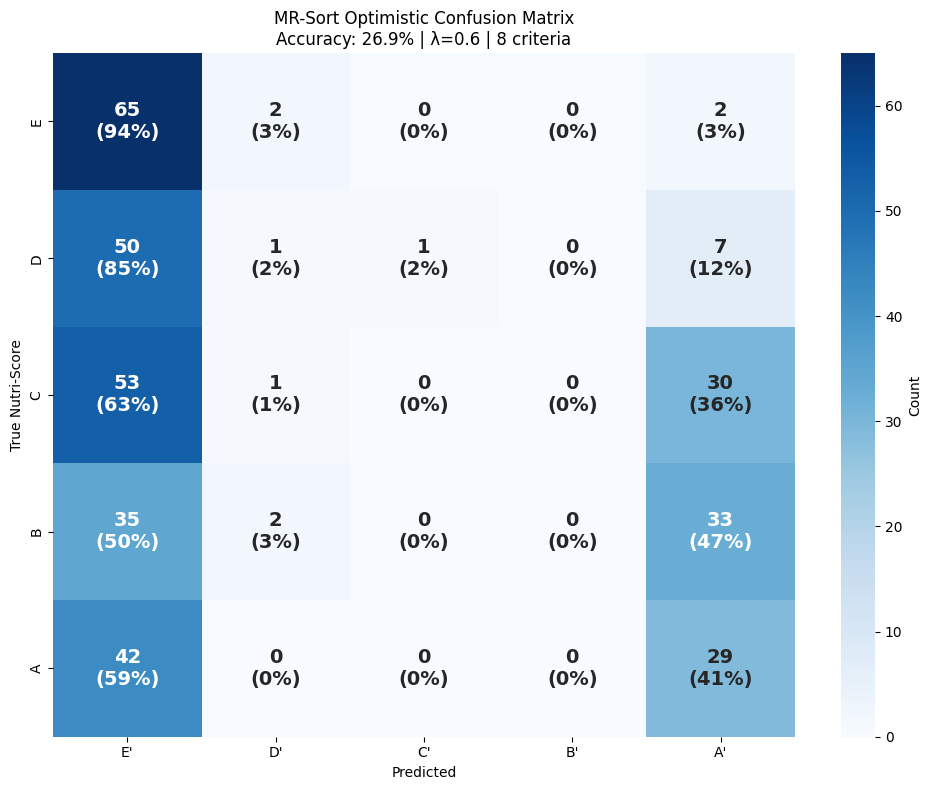


Per-category accuracy:
  E: 94.2% (69 samples)
  D: 1.7% (59 samples)
  C: 0.0% (84 samples)
  B: 0.0% (70 samples)
  A: 40.8% (71 samples)

              precision    recall  f1-score   support

           A       0.29      0.41      0.34        71
           B       0.00      0.00      0.00        70
           C       0.00      0.00      0.00        84
           D       0.17      0.02      0.03        59
           E       0.27      0.94      0.41        69

    accuracy                           0.27       353
   macro avg       0.14      0.27      0.16       353
weighted avg       0.14      0.27      0.15       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 28.3% (100/353)


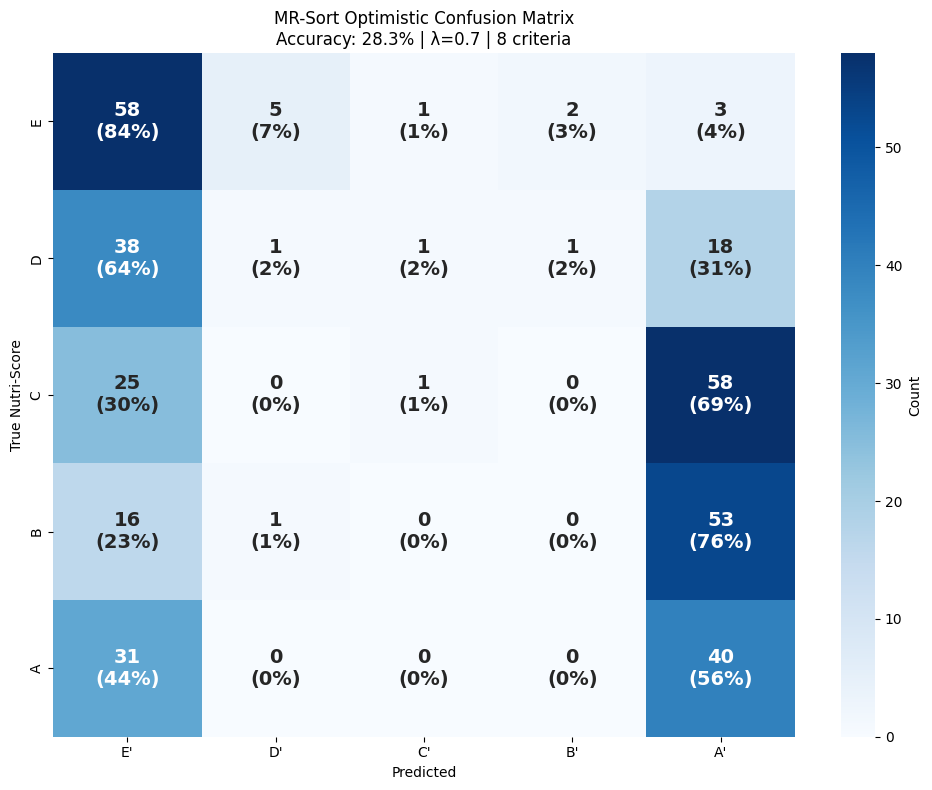


Per-category accuracy:
  E: 84.1% (69 samples)
  D: 1.7% (59 samples)
  C: 1.2% (84 samples)
  B: 0.0% (70 samples)
  A: 56.3% (71 samples)

              precision    recall  f1-score   support

           A       0.23      0.56      0.33        71
           B       0.00      0.00      0.00        70
           C       0.33      0.01      0.02        84
           D       0.14      0.02      0.03        59
           E       0.35      0.84      0.49        69

    accuracy                           0.28       353
   macro avg       0.21      0.29      0.17       353
weighted avg       0.22      0.28      0.17       353



In [19]:
_, _, _, _ = mrsort_confusion_analysis(df, weights_equal_profile, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weights_equal_profile, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weights_equal_profile, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weights_equal_profile, None, method='optimistic', lambda_threshold=0.7)

#### Weights using Entropy

In [20]:
def calculate_entropy_weights(df, criteria_cols):
    """
    Calculate weights using Shannon Entropy method.
    """
    # 1. Normalize data (Max-Min normalization) to avoid negative values for log
    # For entropy, we generally want raw dispersion, direction doesn't matter for the *weight* magnitude
    X = df[criteria_cols].copy()
    
    # Normalize column by column
    for col in X.columns:
        min_val = X[col].min()
        max_val = X[col].max()
        if max_val - min_val != 0:
            X[col] = (X[col] - min_val) / (max_val - min_val)
        else:
            X[col] = 0
            
    # Shift values slightly to avoid log(0)
    X = X + 1e-6
    
    # 2. Calculate P_ij (proportion of the value within the column)
    P = X / X.sum(axis=0)
    
    # 3. Calculate Entropy (E)
    # k is constant
    m, n = X.shape
    k = 1 / np.log(m)
    
    # Compute sum(p * ln(p))
    E = -k * (P * np.log(P)).sum(axis=0)
    
    # 4. Calculate Divergence (d) and Weights (w)
    d = 1 - E
    weights = d / d.sum()
    
    return weights.to_dict()

# Usage
weight_entropy = calculate_entropy_weights(df, criteria_cols)
print(weight_entropy)

{'energy_100g': 0.04349853694544832, 'saturated_fat_100g': 0.20345671254655961, 'sugars_100g': 0.16459952362722058, 'salt_100g': 0.14610427047509125, 'proteins_100g': 0.06535223219342472, 'fiber_100g': 0.1342519886251844, 'fvl_percent': 0.21723857483207637, 'green_score_value': 0.025498160754994725}


✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 41.9% (148/353)


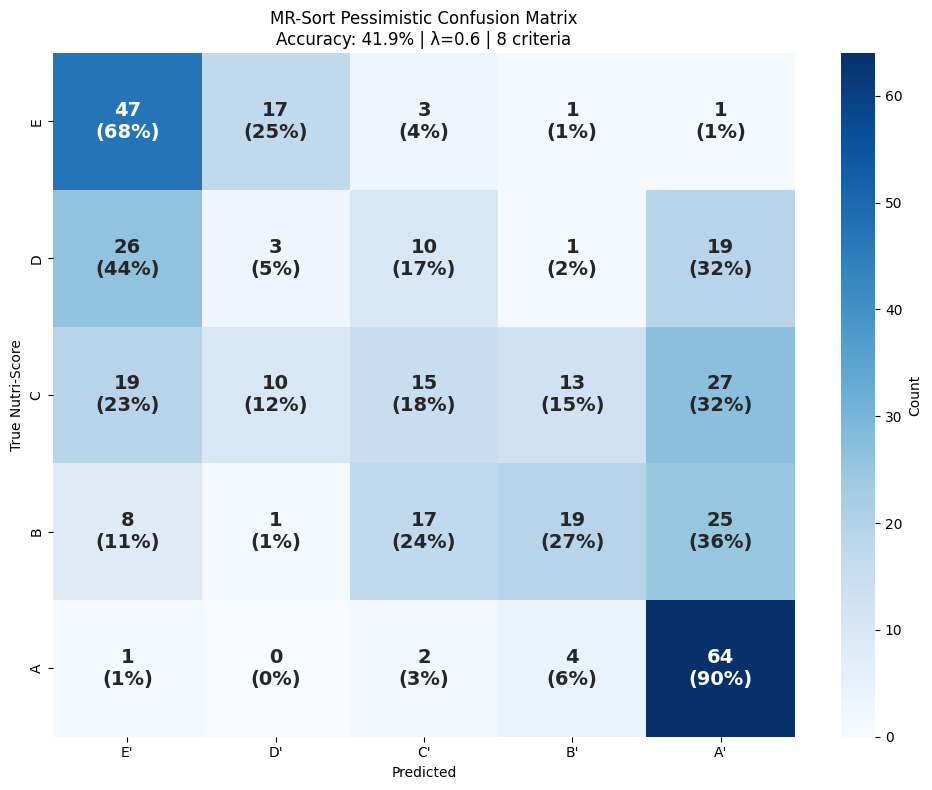


Per-category accuracy:
  E: 68.1% (69 samples)
  D: 5.1% (59 samples)
  C: 17.9% (84 samples)
  B: 27.1% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.90      0.62        71
           B       0.50      0.27      0.35        70
           C       0.32      0.18      0.23        84
           D       0.10      0.05      0.07        59
           E       0.47      0.68      0.55        69

    accuracy                           0.42       353
   macro avg       0.37      0.42      0.36       353
weighted avg       0.38      0.42      0.37       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 29.5% (104/353)


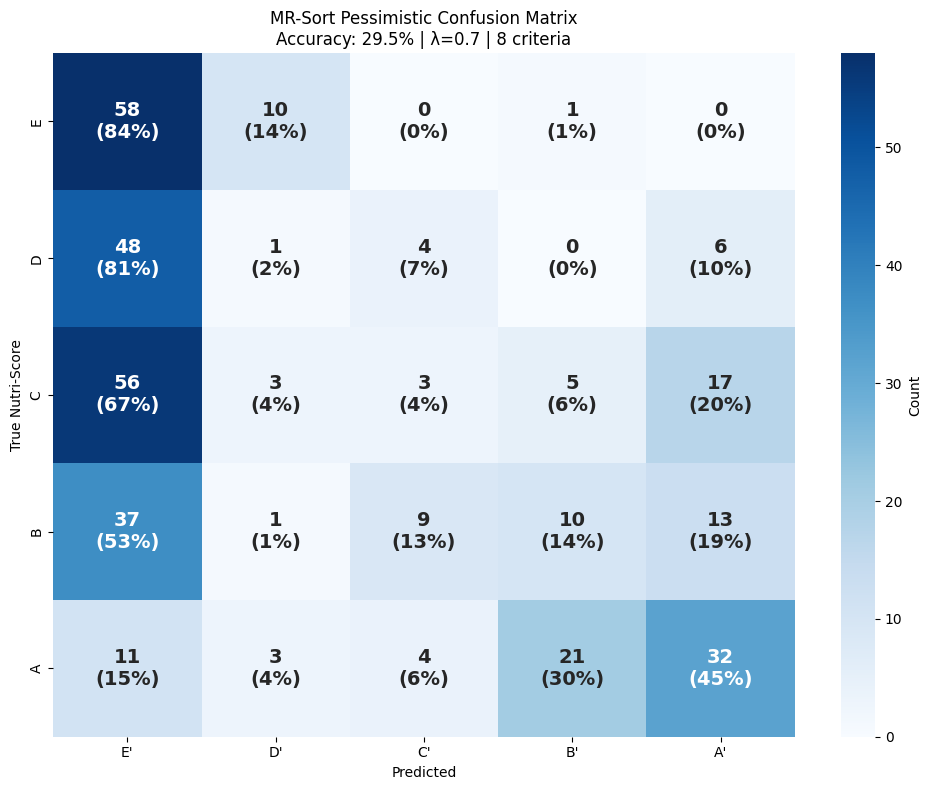


Per-category accuracy:
  E: 84.1% (69 samples)
  D: 1.7% (59 samples)
  C: 3.6% (84 samples)
  B: 14.3% (70 samples)
  A: 45.1% (71 samples)

              precision    recall  f1-score   support

           A       0.47      0.45      0.46        71
           B       0.27      0.14      0.19        70
           C       0.15      0.04      0.06        84
           D       0.06      0.02      0.03        59
           E       0.28      0.84      0.42        69

    accuracy                           0.29       353
   macro avg       0.24      0.30      0.23       353
weighted avg       0.25      0.29      0.23       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 26.1% (92/353)


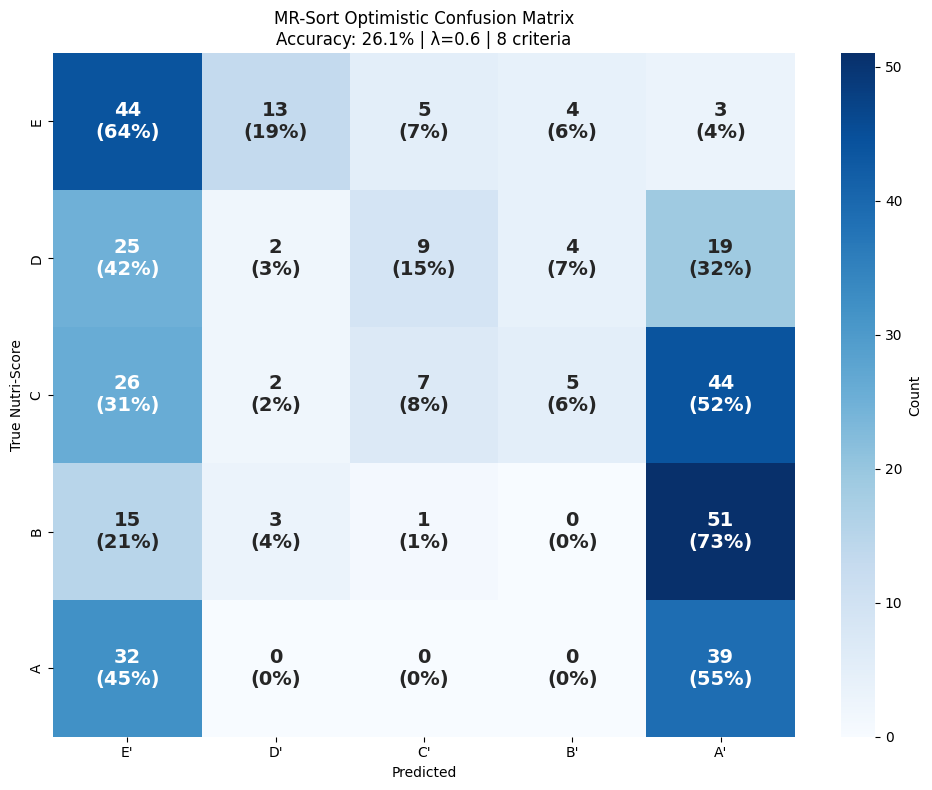


Per-category accuracy:
  E: 63.8% (69 samples)
  D: 3.4% (59 samples)
  C: 8.3% (84 samples)
  B: 0.0% (70 samples)
  A: 54.9% (71 samples)

              precision    recall  f1-score   support

           A       0.25      0.55      0.34        71
           B       0.00      0.00      0.00        70
           C       0.32      0.08      0.13        84
           D       0.10      0.03      0.05        59
           E       0.31      0.64      0.42        69

    accuracy                           0.26       353
   macro avg       0.20      0.26      0.19       353
weighted avg       0.20      0.26      0.19       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.0% (106/353)


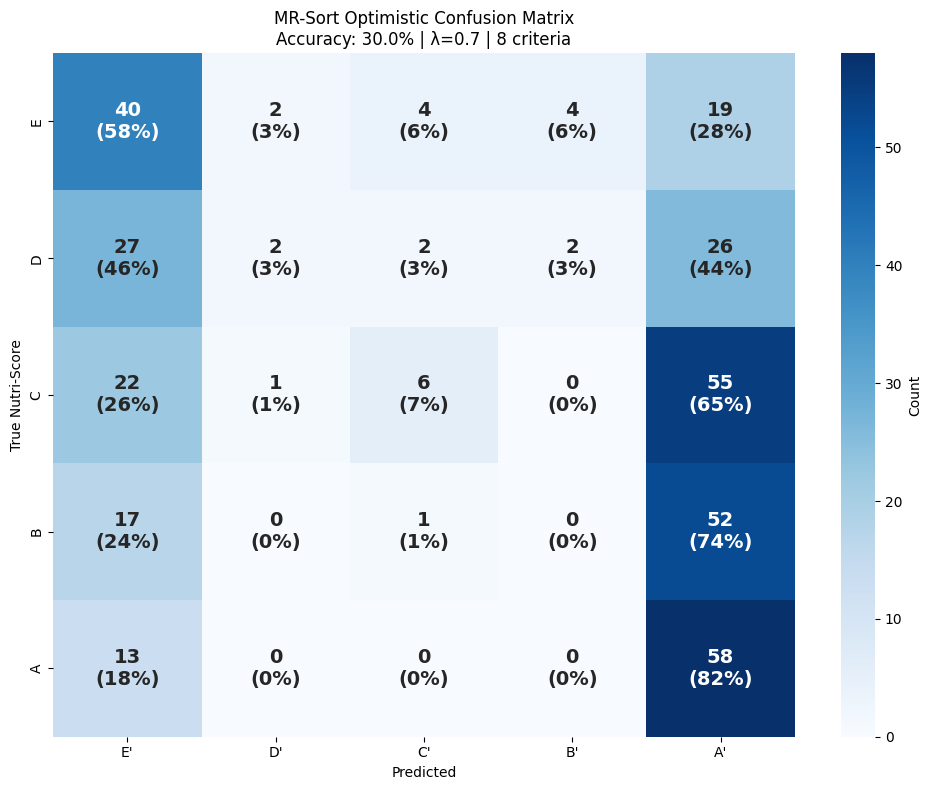


Per-category accuracy:
  E: 58.0% (69 samples)
  D: 3.4% (59 samples)
  C: 7.1% (84 samples)
  B: 0.0% (70 samples)
  A: 81.7% (71 samples)

              precision    recall  f1-score   support

           A       0.28      0.82      0.41        71
           B       0.00      0.00      0.00        70
           C       0.46      0.07      0.12        84
           D       0.40      0.03      0.06        59
           E       0.34      0.58      0.43        69

    accuracy                           0.30       353
   macro avg       0.29      0.30      0.20       353
weighted avg       0.30      0.30      0.21       353



In [21]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, None, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 33.1% (117/353)


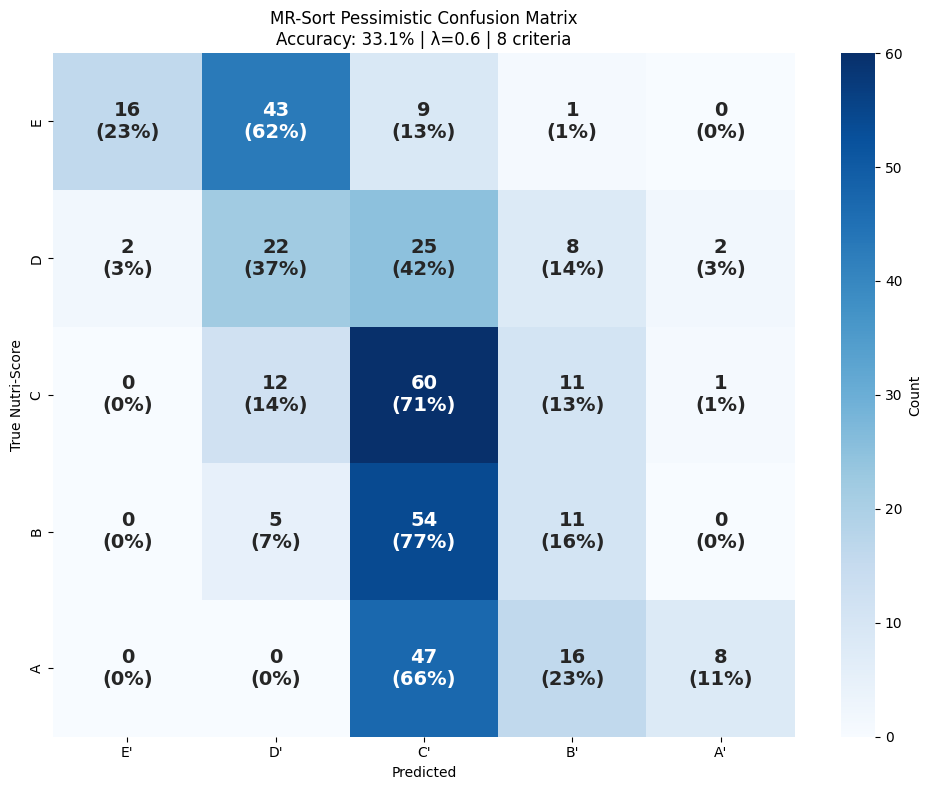


Per-category accuracy:
  E: 23.2% (69 samples)
  D: 37.3% (59 samples)
  C: 71.4% (84 samples)
  B: 15.7% (70 samples)
  A: 11.3% (71 samples)

              precision    recall  f1-score   support

           A       0.73      0.11      0.20        71
           B       0.23      0.16      0.19        70
           C       0.31      0.71      0.43        84
           D       0.27      0.37      0.31        59
           E       0.89      0.23      0.37        69

    accuracy                           0.33       353
   macro avg       0.49      0.32      0.30       353
weighted avg       0.48      0.33      0.30       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 35.4% (125/353)


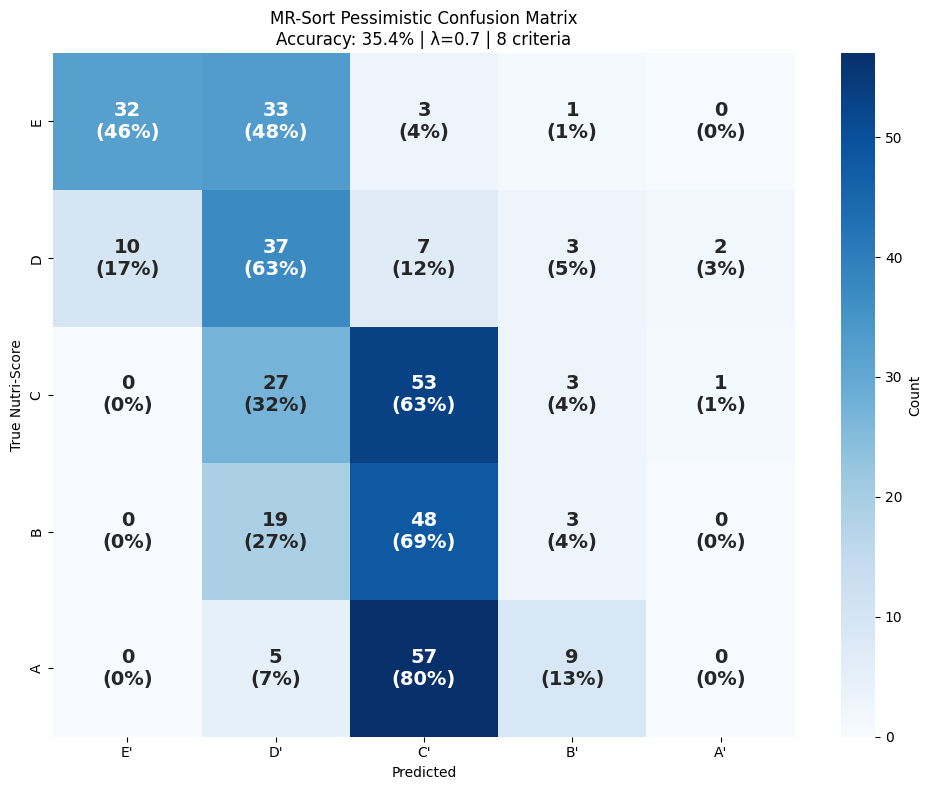


Per-category accuracy:
  E: 46.4% (69 samples)
  D: 62.7% (59 samples)
  C: 63.1% (84 samples)
  B: 4.3% (70 samples)
  A: 0.0% (71 samples)

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        71
           B       0.16      0.04      0.07        70
           C       0.32      0.63      0.42        84
           D       0.31      0.63      0.41        59
           E       0.76      0.46      0.58        69

    accuracy                           0.35       353
   macro avg       0.31      0.35      0.30       353
weighted avg       0.31      0.35      0.29       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 32.3% (114/353)


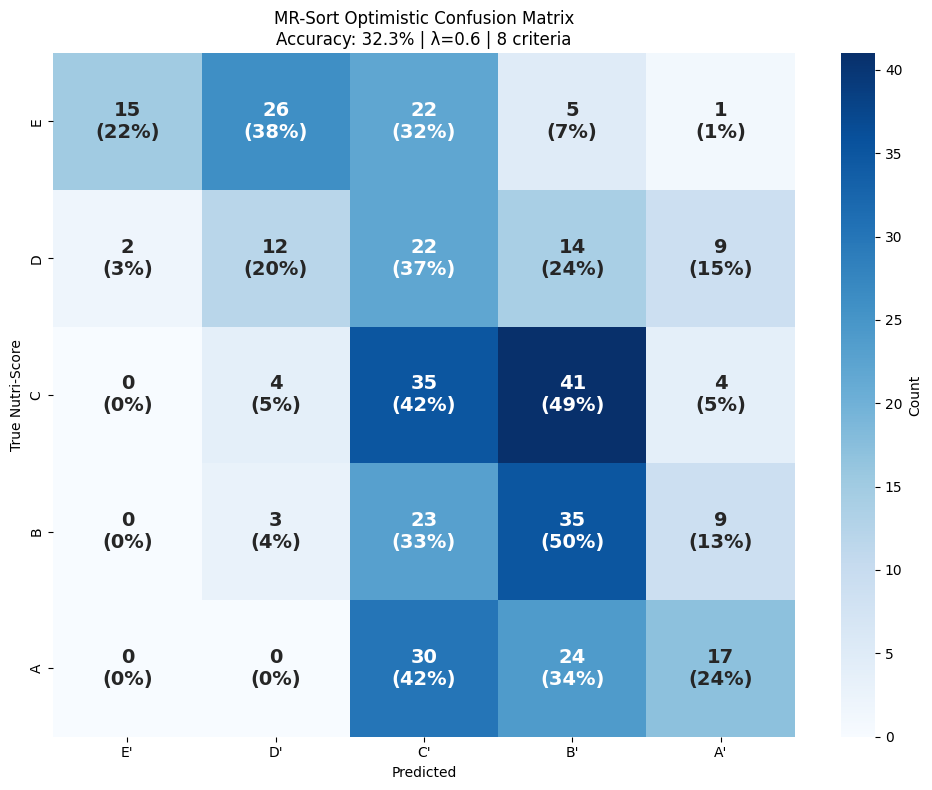


Per-category accuracy:
  E: 21.7% (69 samples)
  D: 20.3% (59 samples)
  C: 41.7% (84 samples)
  B: 50.0% (70 samples)
  A: 23.9% (71 samples)

              precision    recall  f1-score   support

           A       0.42      0.24      0.31        71
           B       0.29      0.50      0.37        70
           C       0.27      0.42      0.32        84
           D       0.27      0.20      0.23        59
           E       0.88      0.22      0.35        69

    accuracy                           0.32       353
   macro avg       0.43      0.32      0.32       353
weighted avg       0.42      0.32      0.32       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 28.3% (100/353)


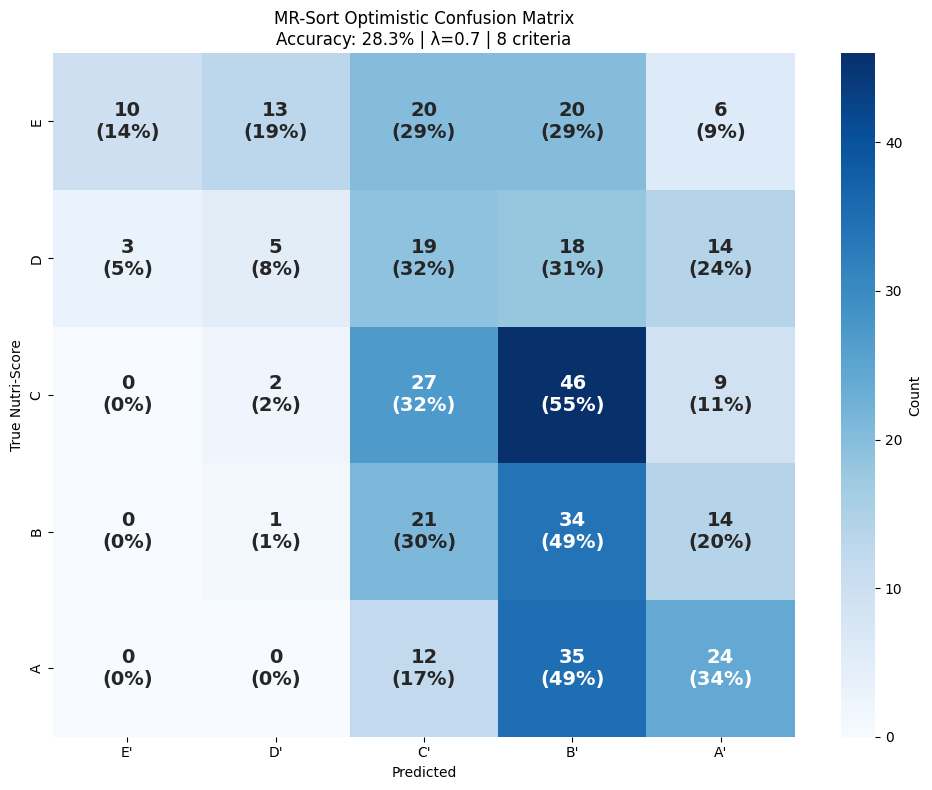


Per-category accuracy:
  E: 14.5% (69 samples)
  D: 8.5% (59 samples)
  C: 32.1% (84 samples)
  B: 48.6% (70 samples)
  A: 33.8% (71 samples)

              precision    recall  f1-score   support

           A       0.36      0.34      0.35        71
           B       0.22      0.49      0.30        70
           C       0.27      0.32      0.30        84
           D       0.24      0.08      0.12        59
           E       0.77      0.14      0.24        69

    accuracy                           0.28       353
   macro avg       0.37      0.27      0.26       353
weighted avg       0.37      0.28      0.27       353



In [22]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_distribution, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_distribution, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_distribution, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_distribution, method='optimistic', lambda_threshold=0.7)

#### Profiles based on Centroid

In [23]:
def create_profiles_centroids(df, criteria_cols):
    print("\n" + "="*60)
    print("2. CALCULATED LIMITING PROFILES (CENTROIDS)")
    print("="*60)

    class_means = df.groupby('nutri_score_label')[criteria_cols].mean()
    
    # Order from Worst (E) to Best (A)
    ordered_classes = ['E', 'D', 'C', 'B', 'A']
    
    profiles_data = []
    
    for i in range(len(ordered_classes) - 1):
        lower_class = ordered_classes[i]
        upper_class = ordered_classes[i+1]
        
        if lower_class in class_means.index and upper_class in class_means.index:
            mean_lower = class_means.loc[lower_class]
            mean_upper = class_means.loc[upper_class]
            profile = (mean_lower + mean_upper) / 2
            profiles_data.append(profile)
        else:
            print(f"Warning: Missing class {lower_class} or {upper_class}")
            
    profiles_df = pd.DataFrame(profiles_data, columns=criteria_cols)
    profiles_df.index = ['π2(E/D)', 'π3(D/C)', 'π4(C/B)', 'π5(B/A)']
    
    return profiles_df

def repair_monotonicity(profiles_df, directions):
    """
    Enforces monotonic constraints on profiles using Isotonic Regression.
    Args:
        profiles_df: The DataFrame of profiles.
        directions: Dictionary mapping column names to 'min' (decreasing) or 'max' (increasing).
    """
    repaired_df = profiles_df.copy()
    
    for col, direction in directions.items():
        if col not in profiles_df.columns:
            continue
            
        values = profiles_df[col].values
        x = np.arange(len(values))
        
        # Fit Isotonic Regression
        # If 'max' (Benefit): Values must INCREASE (E -> A)
        # If 'min' (Cost): Values must DECREASE (E -> A)
        if direction == 'max':
            iso_reg = IsotonicRegression(increasing=True)
        else:
            iso_reg = IsotonicRegression(increasing=False)
            
        # Transform the data to be monotonic
        repaired_values = iso_reg.fit_transform(x, values)
            
        repaired_df[col] = repaired_values
        
    return repaired_df

criteria_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 
                 'salt_100g', 'proteins_100g', 'fiber_100g', 
                 'fvl_percent', 'green_score_value']

criteria_directions = {
    'energy_100g': 'min',
    'saturated_fat_100g': 'min',
    'sugars_100g': 'min',
    'salt_100g': 'min',
    'proteins_100g': 'max',
    'fiber_100g': 'max',
    'fvl_percent': 'max',
    'green_score_value': 'max'
}

raw_profile_centroid = create_profiles_centroids(df, criteria_cols)
profile_centroid = repair_monotonicity(raw_profile_centroid, criteria_directions)
print(profile_centroid)


2. CALCULATED LIMITING PROFILES (CENTROIDS)
         energy_100g  saturated_fat_100g  sugars_100g  salt_100g  proteins_100g  fiber_100g  fvl_percent  green_score_value
π2(E/D)  1546.886146            5.468297    29.169778   1.365509       6.177196    1.995604    12.917865          54.057234
π3(D/C)  1106.435835            2.352101    15.363954   0.840038       6.186341    2.516317    17.189758          59.122458
π4(C/B)   800.607374            1.222661     4.745488   0.722541       7.379179    2.516317    17.189758          59.122458
π5(B/A)   800.607374            0.738283     3.029789   0.524163       9.289594    2.851644    20.607236          60.506740


✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 49.6% (175/353)


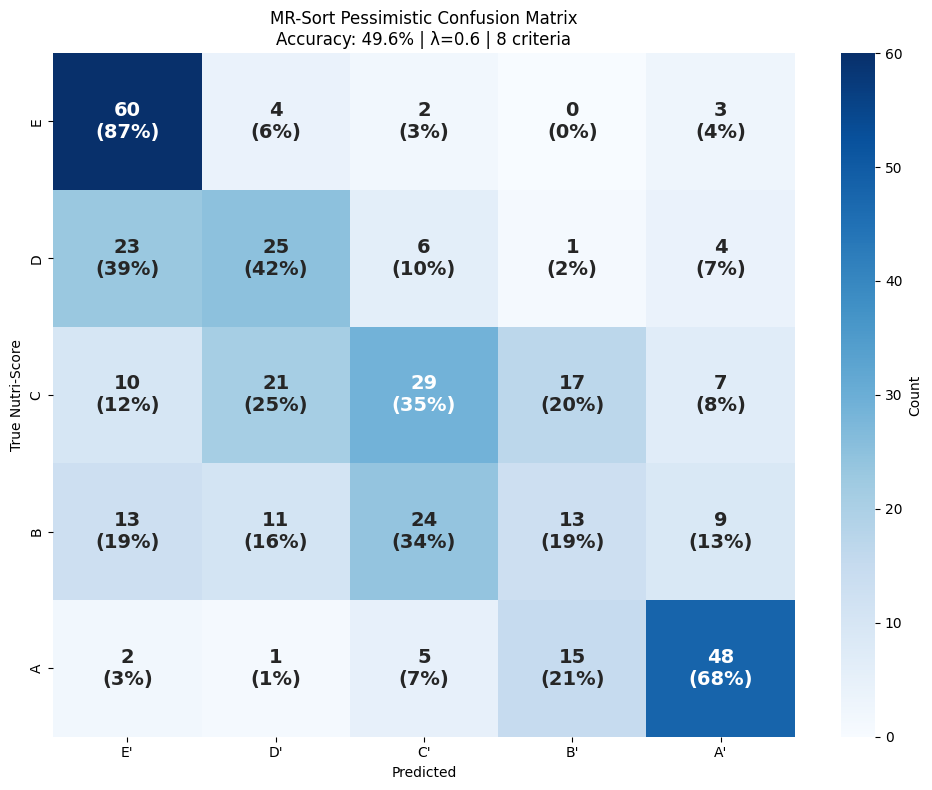


Per-category accuracy:
  E: 87.0% (69 samples)
  D: 42.4% (59 samples)
  C: 34.5% (84 samples)
  B: 18.6% (70 samples)
  A: 67.6% (71 samples)

              precision    recall  f1-score   support

           A       0.68      0.68      0.68        71
           B       0.28      0.19      0.22        70
           C       0.44      0.35      0.39        84
           D       0.40      0.42      0.41        59
           E       0.56      0.87      0.68        69

    accuracy                           0.50       353
   macro avg       0.47      0.50      0.48       353
weighted avg       0.47      0.50      0.47       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 49.6% (175/353)


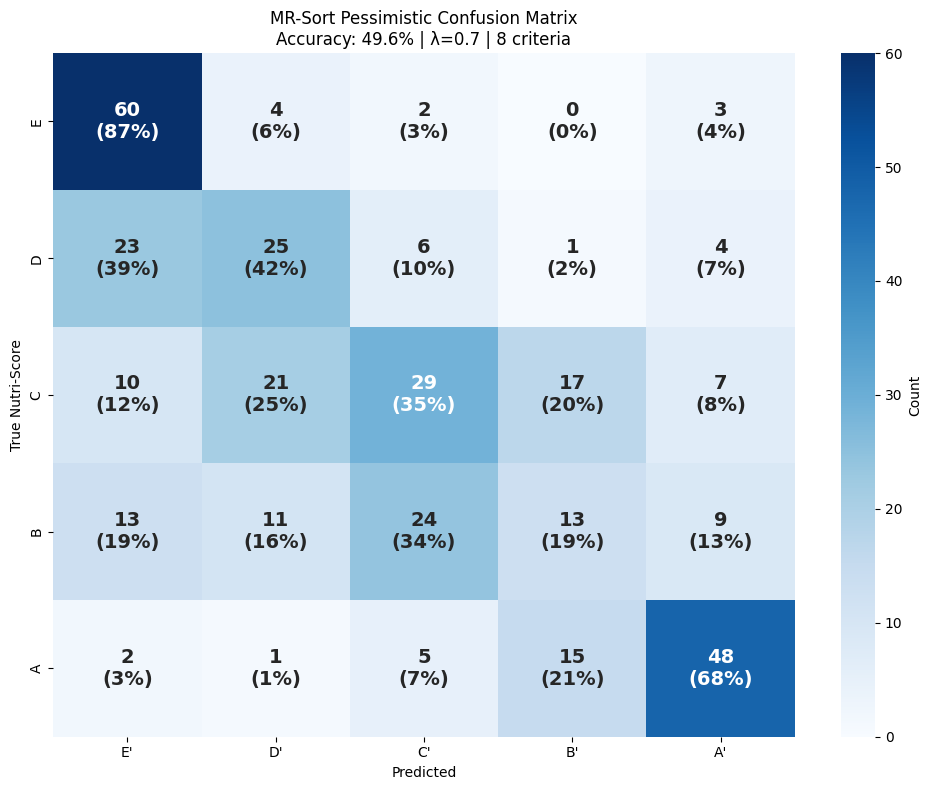


Per-category accuracy:
  E: 87.0% (69 samples)
  D: 42.4% (59 samples)
  C: 34.5% (84 samples)
  B: 18.6% (70 samples)
  A: 67.6% (71 samples)

              precision    recall  f1-score   support

           A       0.68      0.68      0.68        71
           B       0.28      0.19      0.22        70
           C       0.44      0.35      0.39        84
           D       0.40      0.42      0.41        59
           E       0.56      0.87      0.68        69

    accuracy                           0.50       353
   macro avg       0.47      0.50      0.48       353
weighted avg       0.47      0.50      0.47       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 45.0% (159/353)


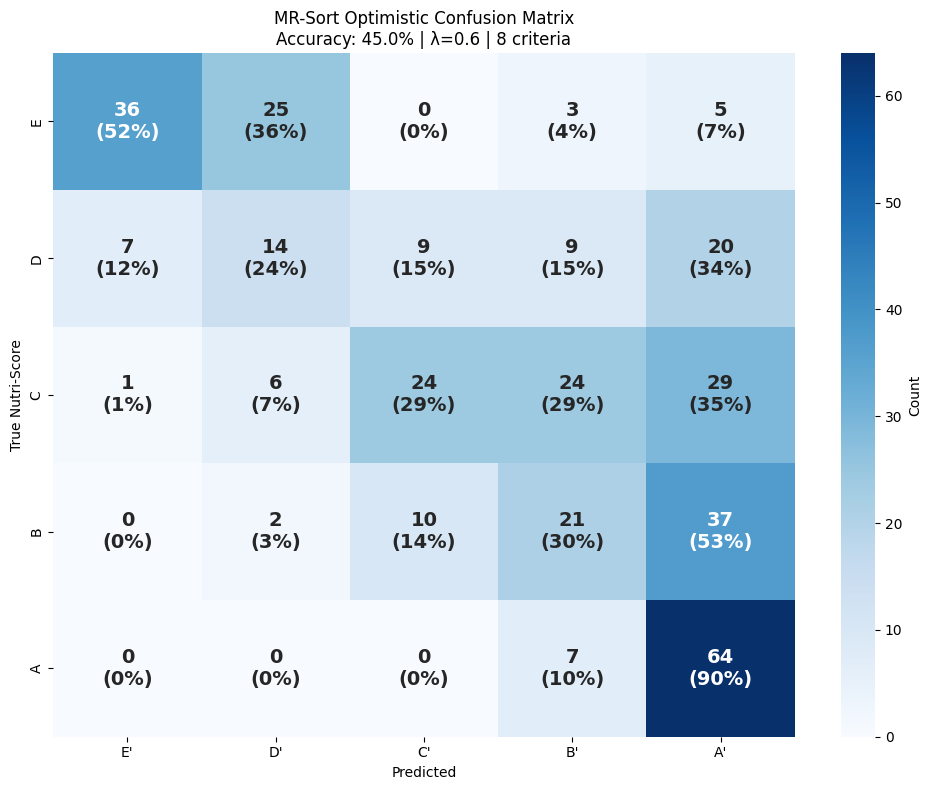


Per-category accuracy:
  E: 52.2% (69 samples)
  D: 23.7% (59 samples)
  C: 28.6% (84 samples)
  B: 30.0% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.41      0.90      0.57        71
           B       0.33      0.30      0.31        70
           C       0.56      0.29      0.38        84
           D       0.30      0.24      0.26        59
           E       0.82      0.52      0.64        69

    accuracy                           0.45       353
   macro avg       0.48      0.45      0.43       353
weighted avg       0.49      0.45      0.43       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 45.0% (159/353)


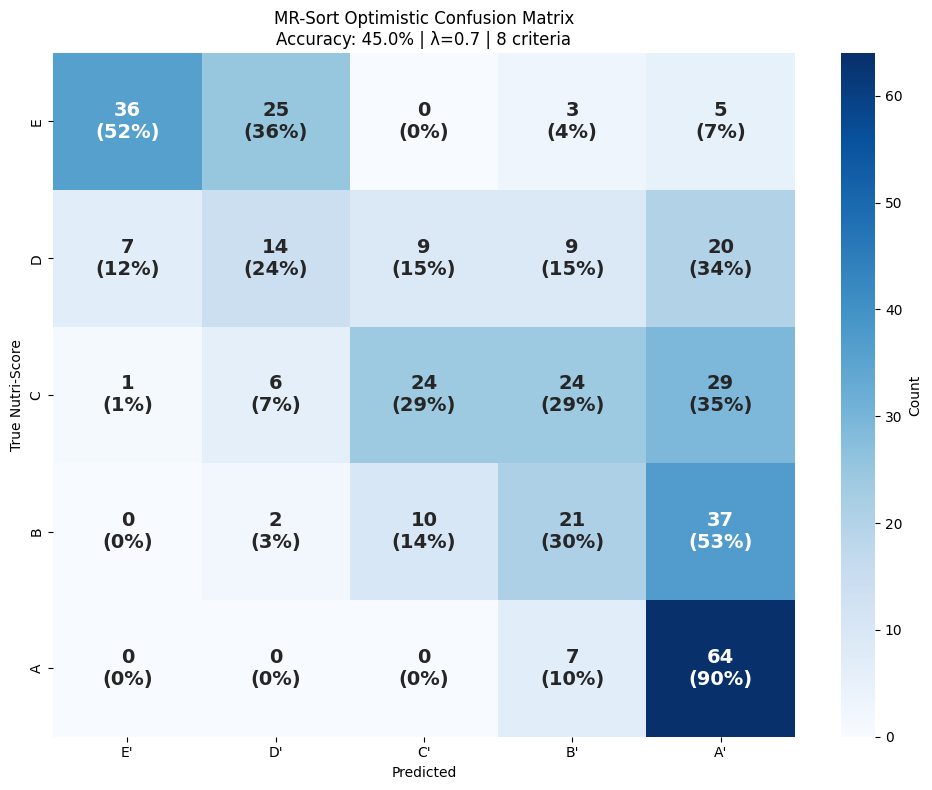


Per-category accuracy:
  E: 52.2% (69 samples)
  D: 23.7% (59 samples)
  C: 28.6% (84 samples)
  B: 30.0% (70 samples)
  A: 90.1% (71 samples)

              precision    recall  f1-score   support

           A       0.41      0.90      0.57        71
           B       0.33      0.30      0.31        70
           C       0.56      0.29      0.38        84
           D       0.30      0.24      0.26        59
           E       0.82      0.52      0.64        69

    accuracy                           0.45       353
   macro avg       0.48      0.45      0.43       353
weighted avg       0.49      0.45      0.43       353



In [24]:
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_centroid, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_centroid, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_centroid, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_centroid, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 46.2% (163/353)


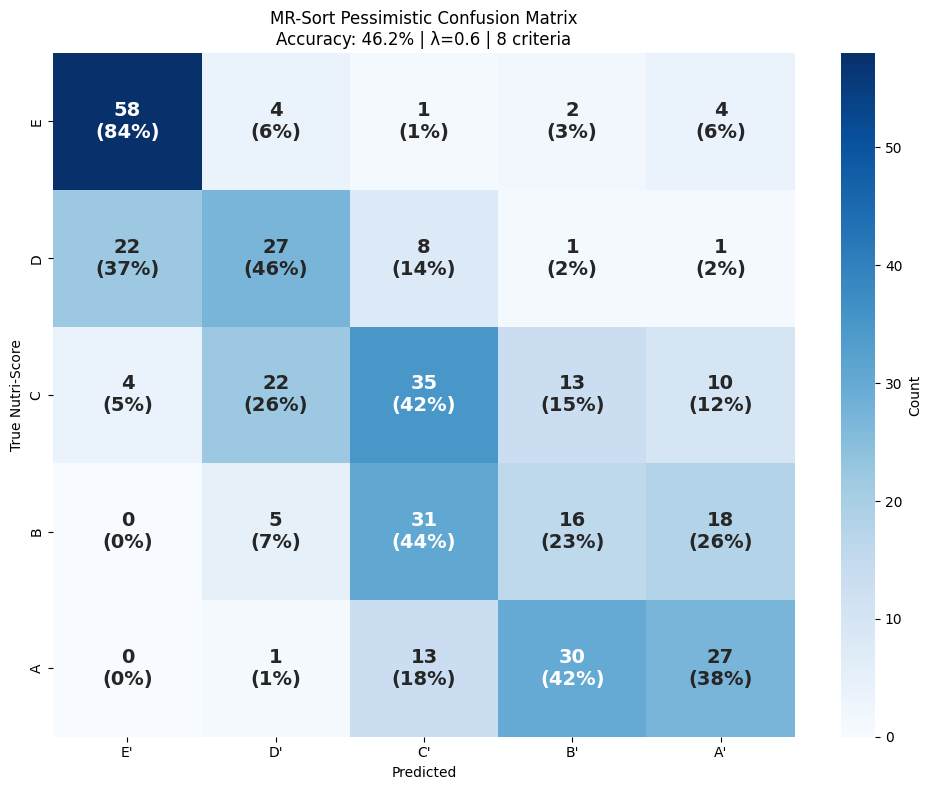


Per-category accuracy:
  E: 84.1% (69 samples)
  D: 45.8% (59 samples)
  C: 41.7% (84 samples)
  B: 22.9% (70 samples)
  A: 38.0% (71 samples)

              precision    recall  f1-score   support

           A       0.45      0.38      0.41        71
           B       0.26      0.23      0.24        70
           C       0.40      0.42      0.41        84
           D       0.46      0.46      0.46        59
           E       0.69      0.84      0.76        69

    accuracy                           0.46       353
   macro avg       0.45      0.46      0.46       353
weighted avg       0.45      0.46      0.45       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 31.7% (112/353)


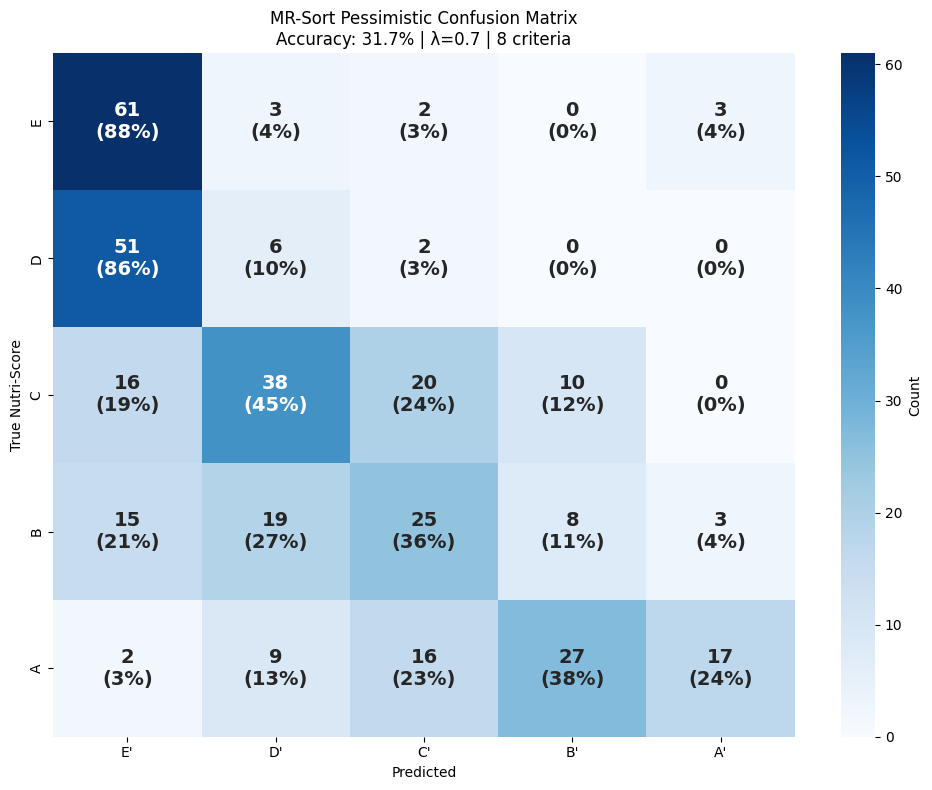


Per-category accuracy:
  E: 88.4% (69 samples)
  D: 10.2% (59 samples)
  C: 23.8% (84 samples)
  B: 11.4% (70 samples)
  A: 23.9% (71 samples)

              precision    recall  f1-score   support

           A       0.74      0.24      0.36        71
           B       0.18      0.11      0.14        70
           C       0.31      0.24      0.27        84
           D       0.08      0.10      0.09        59
           E       0.42      0.88      0.57        69

    accuracy                           0.32       353
   macro avg       0.35      0.32      0.29       353
weighted avg       0.35      0.32      0.29       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 40.2% (142/353)


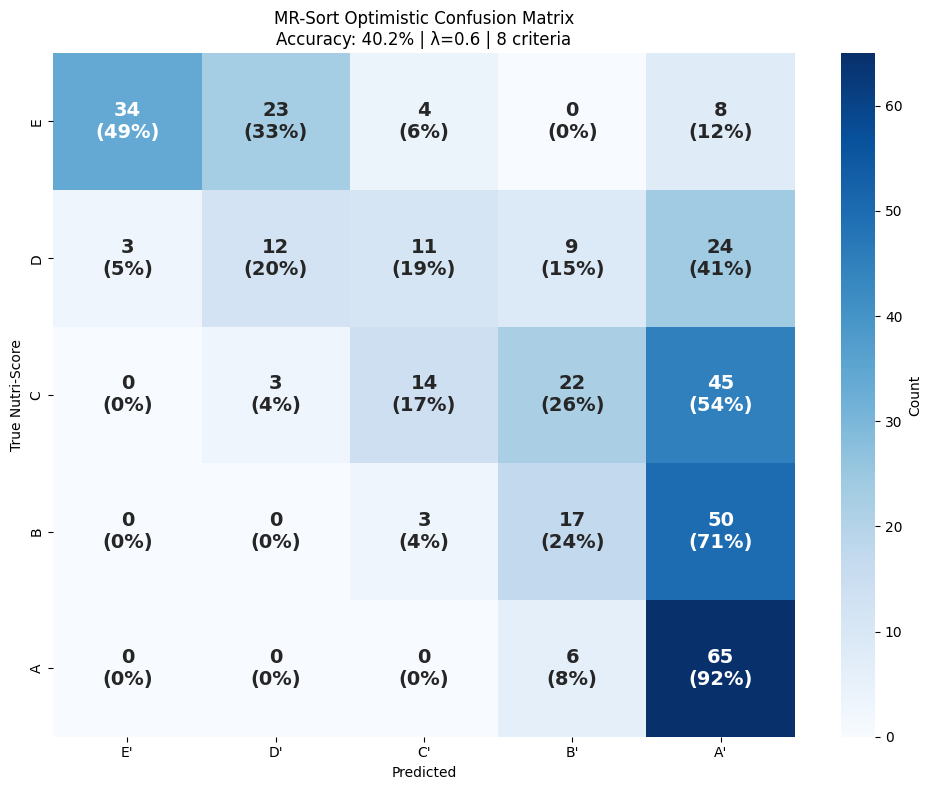


Per-category accuracy:
  E: 49.3% (69 samples)
  D: 20.3% (59 samples)
  C: 16.7% (84 samples)
  B: 24.3% (70 samples)
  A: 91.5% (71 samples)

              precision    recall  f1-score   support

           A       0.34      0.92      0.49        71
           B       0.31      0.24      0.27        70
           C       0.44      0.17      0.24        84
           D       0.32      0.20      0.25        59
           E       0.92      0.49      0.64        69

    accuracy                           0.40       353
   macro avg       0.47      0.40      0.38       353
weighted avg       0.47      0.40      0.38       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


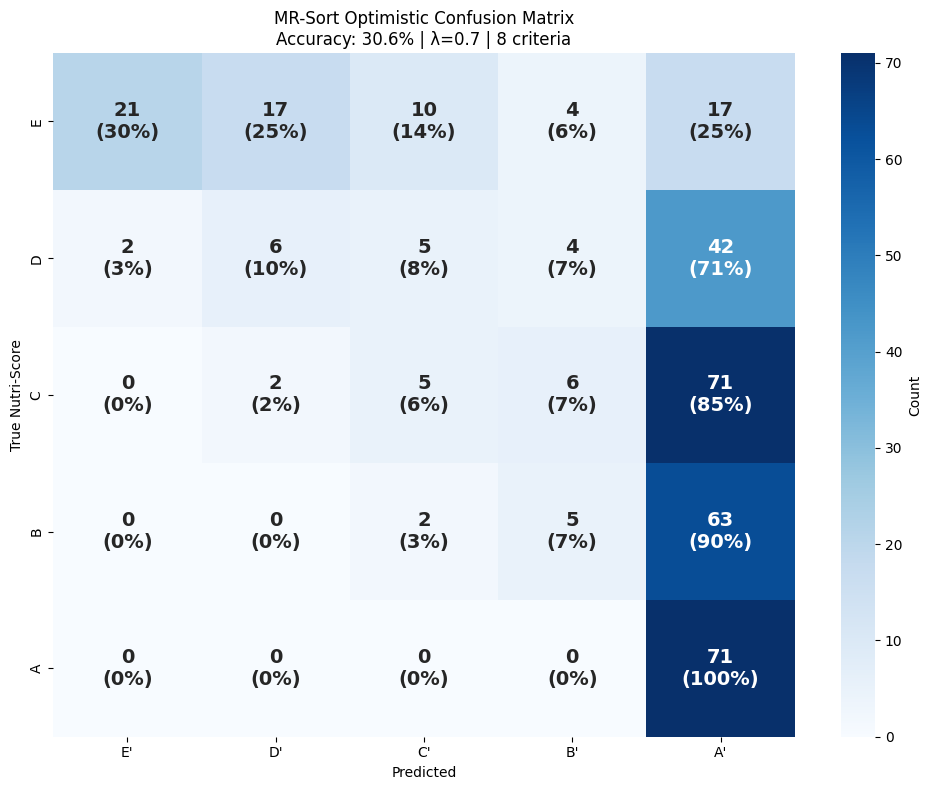


Per-category accuracy:
  E: 30.4% (69 samples)
  D: 10.2% (59 samples)
  C: 6.0% (84 samples)
  B: 7.1% (70 samples)
  A: 100.0% (71 samples)

              precision    recall  f1-score   support

           A       0.27      1.00      0.42        71
           B       0.26      0.07      0.11        70
           C       0.23      0.06      0.09        84
           D       0.24      0.10      0.14        59
           E       0.91      0.30      0.46        69

    accuracy                           0.31       353
   macro avg       0.38      0.31      0.25       353
weighted avg       0.38      0.31      0.24       353



In [25]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_centroid, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_centroid, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_centroid, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, profile_centroid, method='optimistic', lambda_threshold=0.7)

In [26]:
weights_centroid_optimized = optimize_weights_mrsort(df, profile_centroid, 0.7, criteria_cols, criteria_directions)
print(weights_centroid_optimized)

Optimizing weights... (this may take a moment)
Optimization Complete. Best Accuracy: 47.31%
{'energy_100g': np.float64(0.11530288035241762), 'saturated_fat_100g': np.float64(0.33140330093530984), 'sugars_100g': np.float64(0.04784351853730483), 'salt_100g': np.float64(0.2326170647485641), 'proteins_100g': np.float64(0.23273561915659774), 'fiber_100g': np.float64(0.012936620657182414), 'fvl_percent': np.float64(0.019398709270099544), 'green_score_value': np.float64(0.007762286342523892)}


✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 50.7% (179/353)


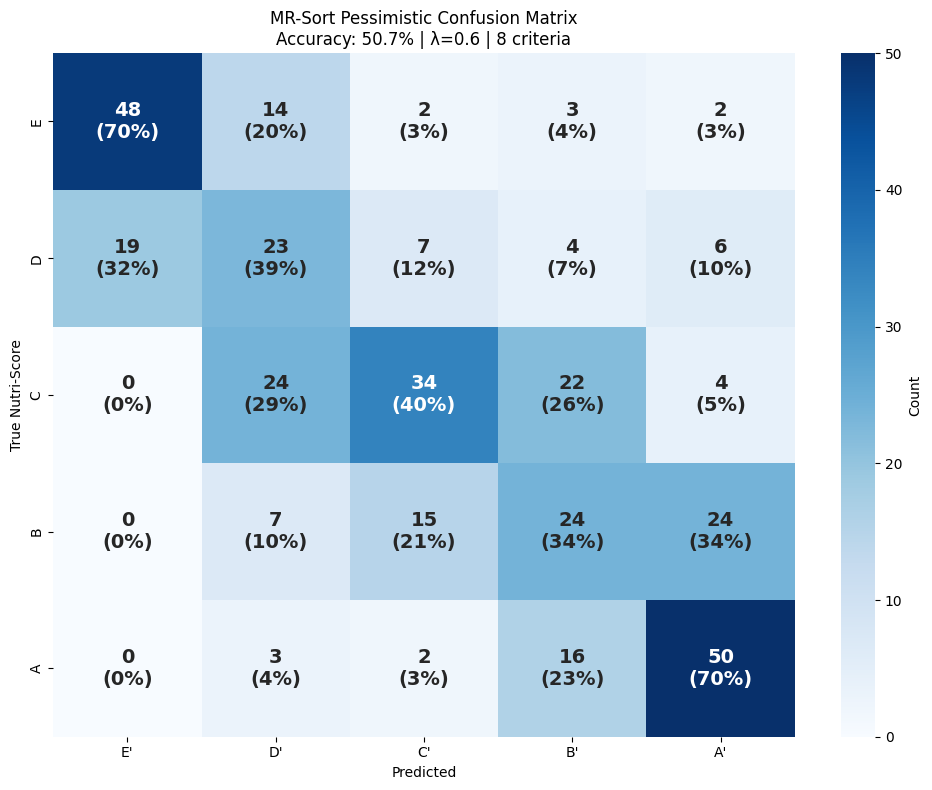


Per-category accuracy:
  E: 69.6% (69 samples)
  D: 39.0% (59 samples)
  C: 40.5% (84 samples)
  B: 34.3% (70 samples)
  A: 70.4% (71 samples)

              precision    recall  f1-score   support

           A       0.58      0.70      0.64        71
           B       0.35      0.34      0.35        70
           C       0.57      0.40      0.47        84
           D       0.32      0.39      0.35        59
           E       0.72      0.70      0.71        69

    accuracy                           0.51       353
   macro avg       0.51      0.51      0.50       353
weighted avg       0.51      0.51      0.51       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 47.3% (167/353)


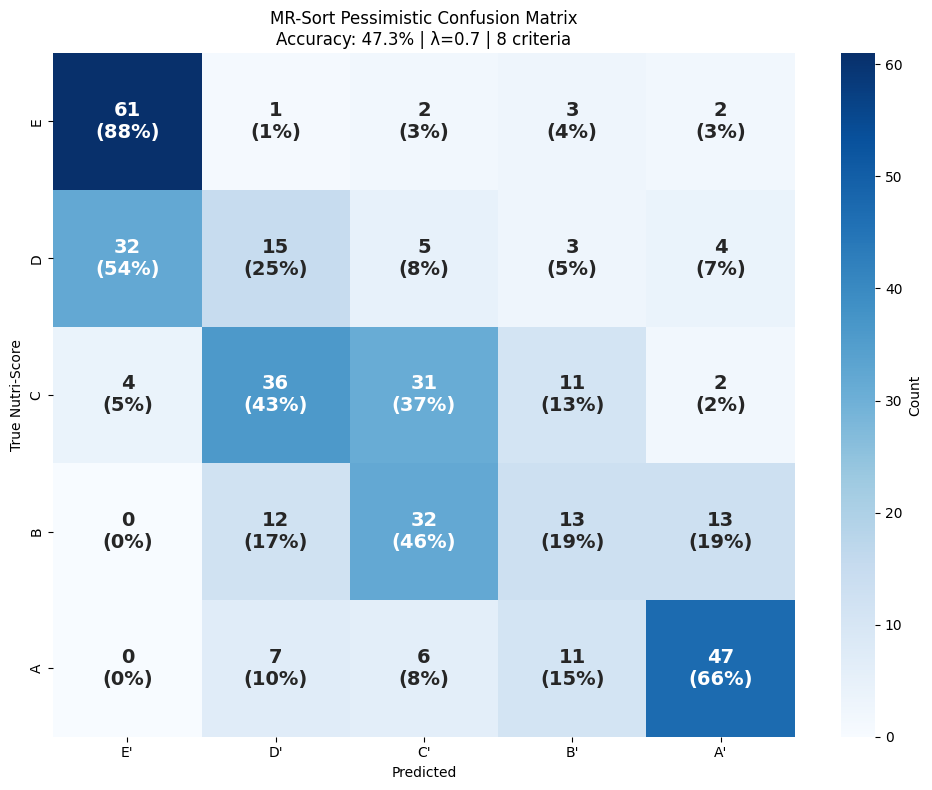


Per-category accuracy:
  E: 88.4% (69 samples)
  D: 25.4% (59 samples)
  C: 36.9% (84 samples)
  B: 18.6% (70 samples)
  A: 66.2% (71 samples)

              precision    recall  f1-score   support

           A       0.69      0.66      0.68        71
           B       0.32      0.19      0.23        70
           C       0.41      0.37      0.39        84
           D       0.21      0.25      0.23        59
           E       0.63      0.88      0.73        69

    accuracy                           0.47       353
   macro avg       0.45      0.47      0.45       353
weighted avg       0.46      0.47      0.46       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 35.7% (126/353)


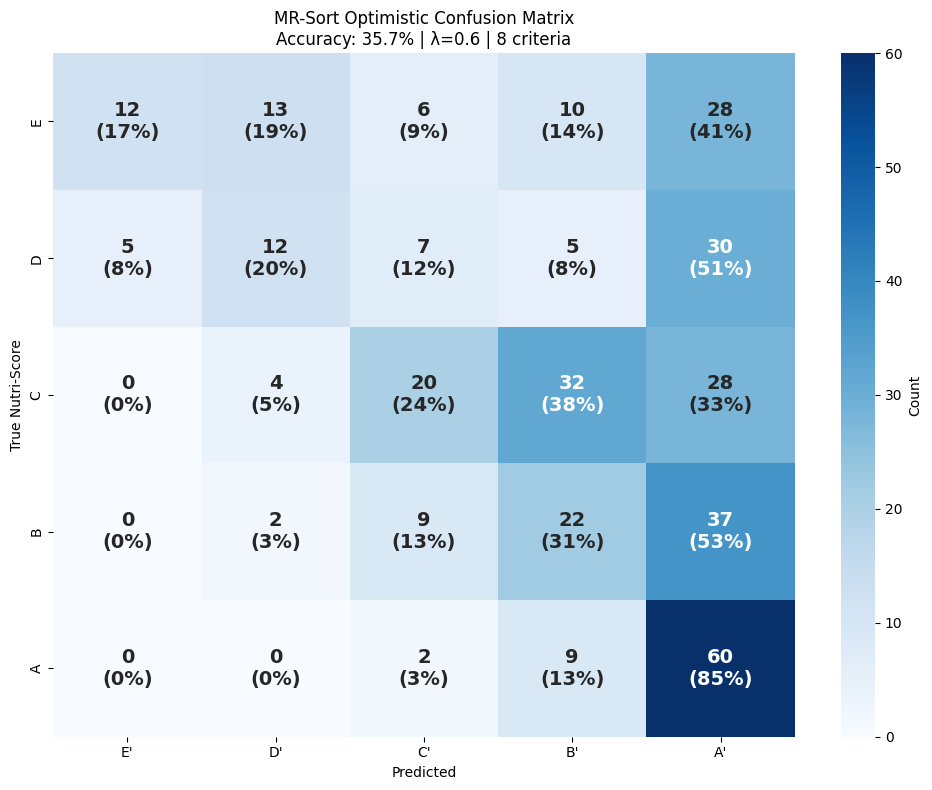


Per-category accuracy:
  E: 17.4% (69 samples)
  D: 20.3% (59 samples)
  C: 23.8% (84 samples)
  B: 31.4% (70 samples)
  A: 84.5% (71 samples)

              precision    recall  f1-score   support

           A       0.33      0.85      0.47        71
           B       0.28      0.31      0.30        70
           C       0.45      0.24      0.31        84
           D       0.39      0.20      0.27        59
           E       0.71      0.17      0.28        69

    accuracy                           0.36       353
   macro avg       0.43      0.35      0.33       353
weighted avg       0.43      0.36      0.33       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 33.1% (117/353)


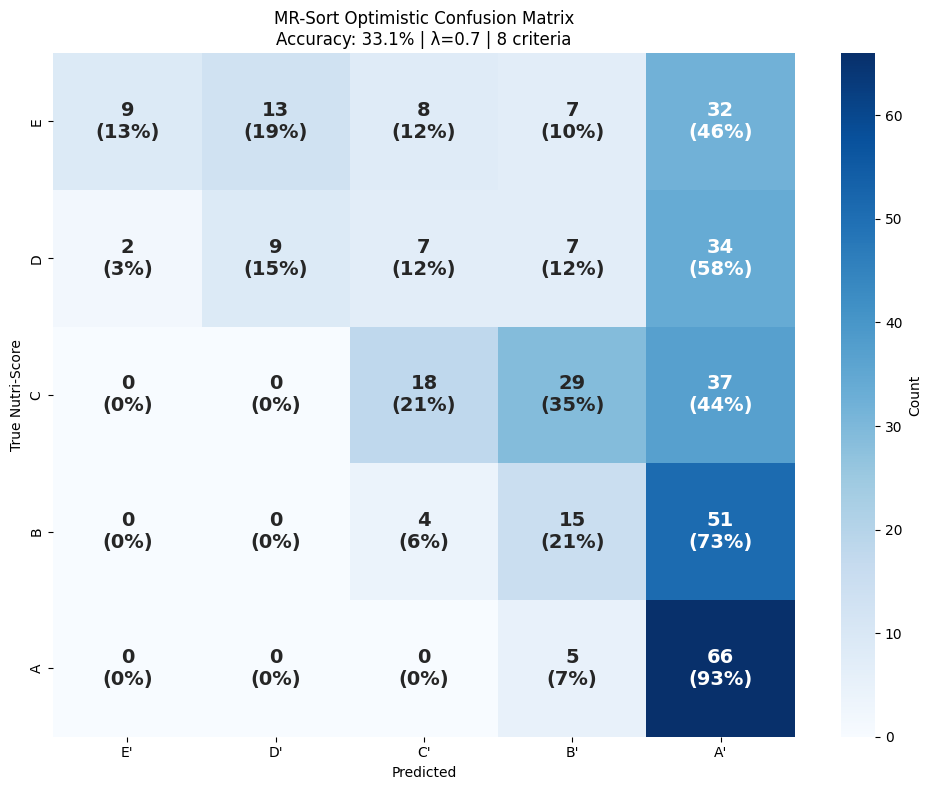


Per-category accuracy:
  E: 13.0% (69 samples)
  D: 15.3% (59 samples)
  C: 21.4% (84 samples)
  B: 21.4% (70 samples)
  A: 93.0% (71 samples)

              precision    recall  f1-score   support

           A       0.30      0.93      0.45        71
           B       0.24      0.21      0.23        70
           C       0.49      0.21      0.30        84
           D       0.41      0.15      0.22        59
           E       0.82      0.13      0.23        69

    accuracy                           0.33       353
   macro avg       0.45      0.33      0.28       353
weighted avg       0.45      0.33      0.29       353



In [27]:
_, _, _, _ = mrsort_confusion_analysis(df, weights_centroid_optimized, profile_centroid, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weights_centroid_optimized, profile_centroid, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weights_centroid_optimized, profile_centroid, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weights_centroid_optimized, profile_centroid, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 35.4% (125/353)


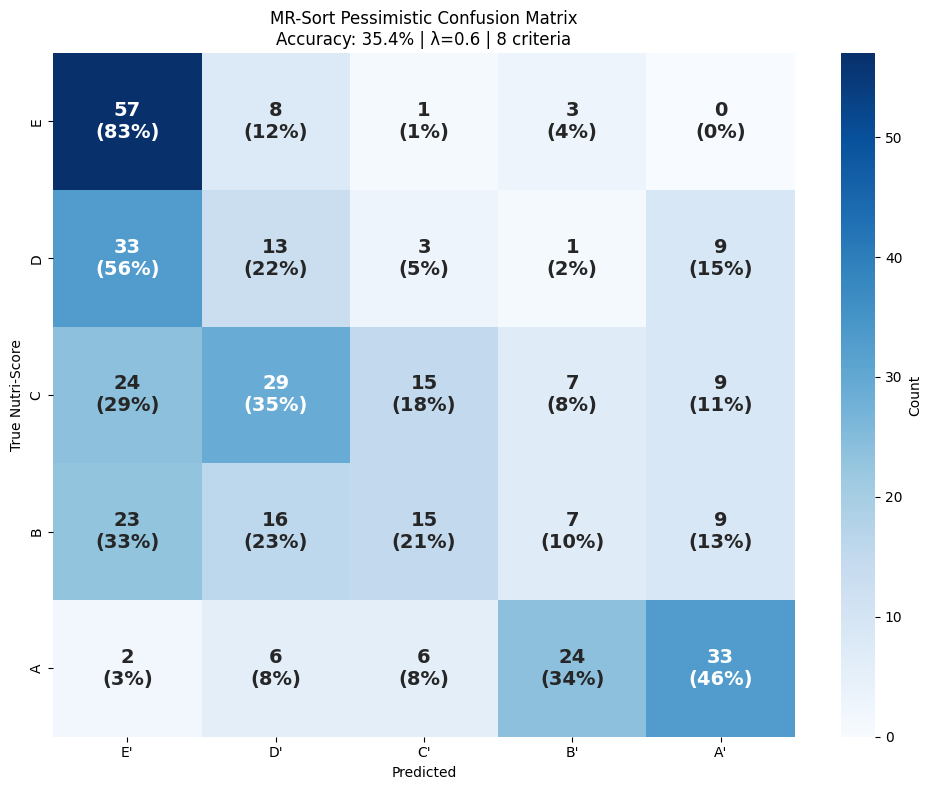


Per-category accuracy:
  E: 82.6% (69 samples)
  D: 22.0% (59 samples)
  C: 17.9% (84 samples)
  B: 10.0% (70 samples)
  A: 46.5% (71 samples)

              precision    recall  f1-score   support

           A       0.55      0.46      0.50        71
           B       0.17      0.10      0.12        70
           C       0.38      0.18      0.24        84
           D       0.18      0.22      0.20        59
           E       0.41      0.83      0.55        69

    accuracy                           0.35       353
   macro avg       0.34      0.36      0.32       353
weighted avg       0.34      0.35      0.32       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 28.3% (100/353)


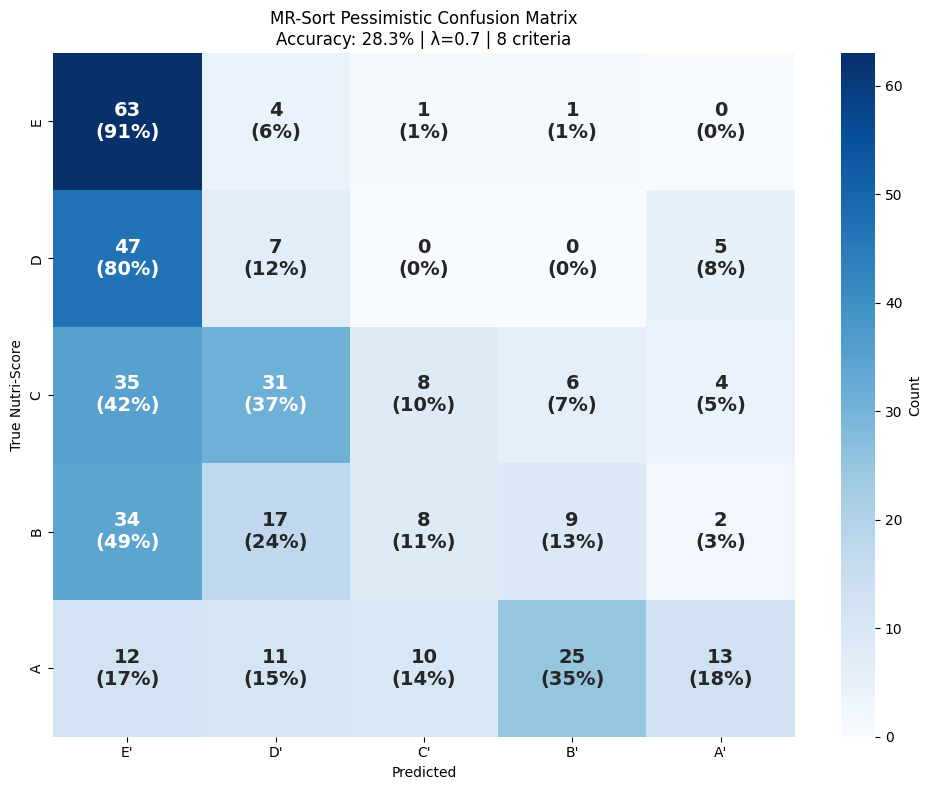


Per-category accuracy:
  E: 91.3% (69 samples)
  D: 11.9% (59 samples)
  C: 9.5% (84 samples)
  B: 12.9% (70 samples)
  A: 18.3% (71 samples)

              precision    recall  f1-score   support

           A       0.54      0.18      0.27        71
           B       0.22      0.13      0.16        70
           C       0.30      0.10      0.14        84
           D       0.10      0.12      0.11        59
           E       0.33      0.91      0.48        69

    accuracy                           0.28       353
   macro avg       0.30      0.29      0.23       353
weighted avg       0.30      0.28      0.23       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 44.8% (158/353)


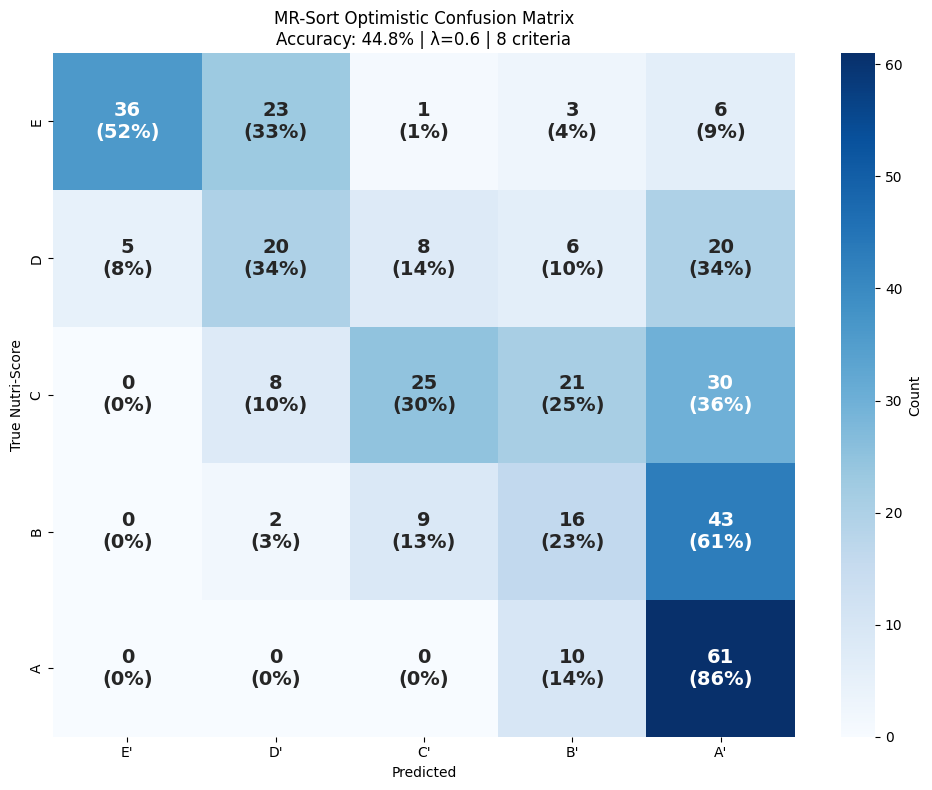


Per-category accuracy:
  E: 52.2% (69 samples)
  D: 33.9% (59 samples)
  C: 29.8% (84 samples)
  B: 22.9% (70 samples)
  A: 85.9% (71 samples)

              precision    recall  f1-score   support

           A       0.38      0.86      0.53        71
           B       0.29      0.23      0.25        70
           C       0.58      0.30      0.39        84
           D       0.38      0.34      0.36        59
           E       0.88      0.52      0.65        69

    accuracy                           0.45       353
   macro avg       0.50      0.45      0.44       353
weighted avg       0.51      0.45      0.44       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 33.1% (117/353)


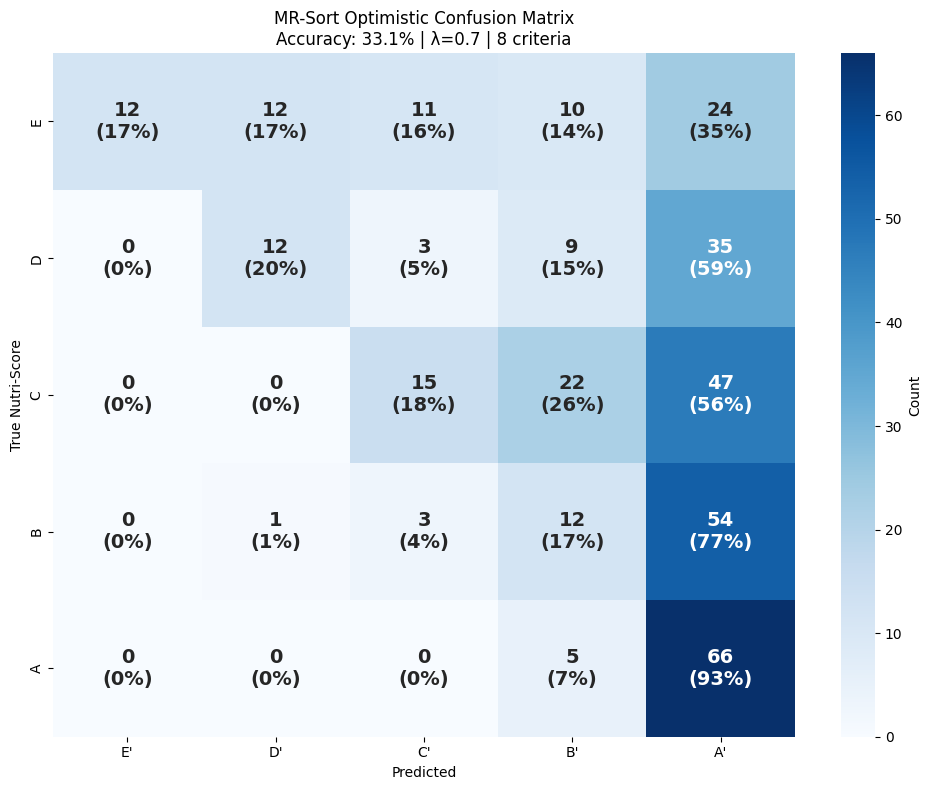


Per-category accuracy:
  E: 17.4% (69 samples)
  D: 20.3% (59 samples)
  C: 17.9% (84 samples)
  B: 17.1% (70 samples)
  A: 93.0% (71 samples)

              precision    recall  f1-score   support

           A       0.29      0.93      0.44        71
           B       0.21      0.17      0.19        70
           C       0.47      0.18      0.26        84
           D       0.48      0.20      0.29        59
           E       1.00      0.17      0.30        69

    accuracy                           0.33       353
   macro avg       0.49      0.33      0.29       353
weighted avg       0.49      0.33      0.29       353



In [28]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_centroid, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_centroid, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_centroid, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_entropy, profile_centroid, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 31.2% (110/353)


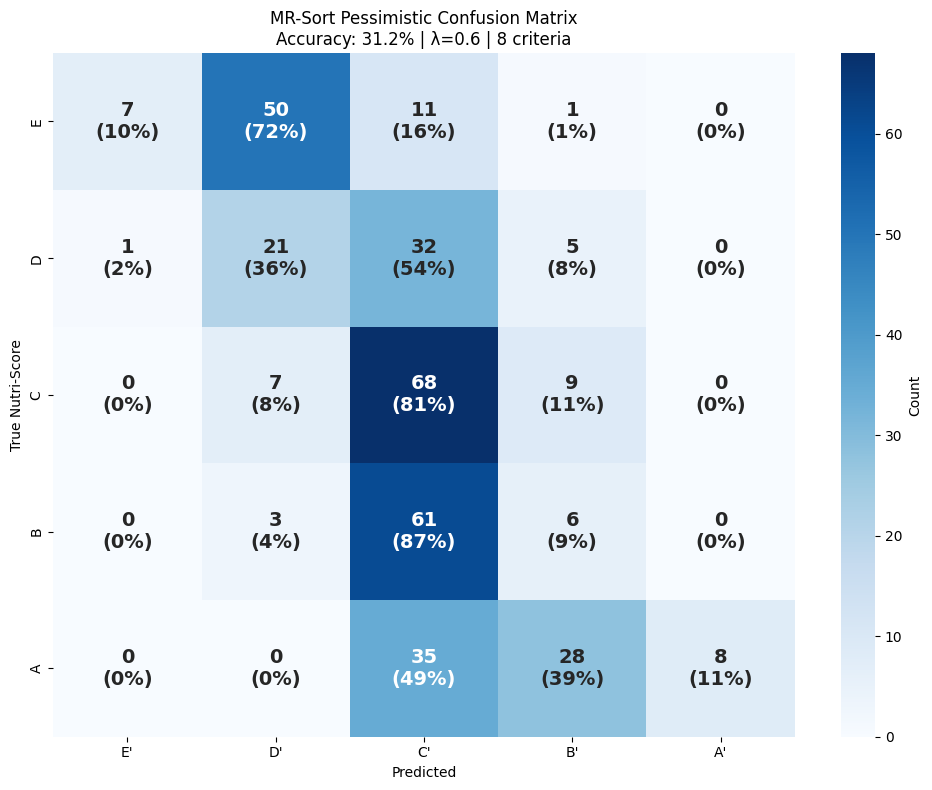


Per-category accuracy:
  E: 10.1% (69 samples)
  D: 35.6% (59 samples)
  C: 81.0% (84 samples)
  B: 8.6% (70 samples)
  A: 11.3% (71 samples)

              precision    recall  f1-score   support

           A       1.00      0.11      0.20        71
           B       0.12      0.09      0.10        70
           C       0.33      0.81      0.47        84
           D       0.26      0.36      0.30        59
           E       0.88      0.10      0.18        69

    accuracy                           0.31       353
   macro avg       0.52      0.29      0.25       353
weighted avg       0.52      0.31      0.26       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 31.2% (110/353)


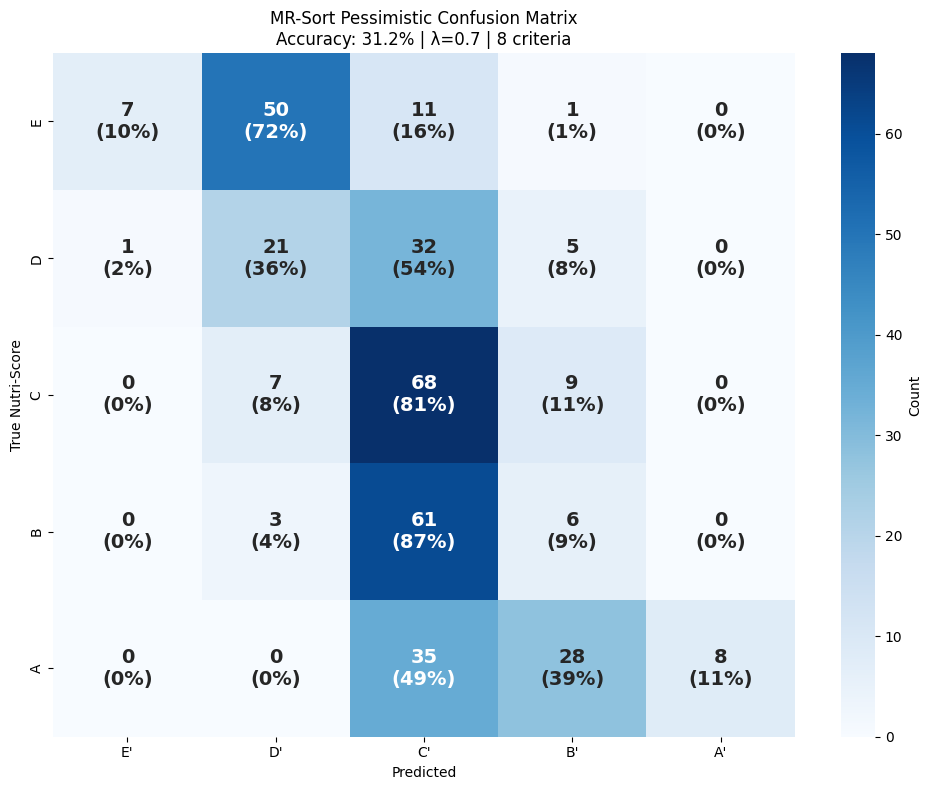


Per-category accuracy:
  E: 10.1% (69 samples)
  D: 35.6% (59 samples)
  C: 81.0% (84 samples)
  B: 8.6% (70 samples)
  A: 11.3% (71 samples)

              precision    recall  f1-score   support

           A       1.00      0.11      0.20        71
           B       0.12      0.09      0.10        70
           C       0.33      0.81      0.47        84
           D       0.26      0.36      0.30        59
           E       0.88      0.10      0.18        69

    accuracy                           0.31       353
   macro avg       0.52      0.29      0.25       353
weighted avg       0.52      0.31      0.26       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 31.2% (110/353)


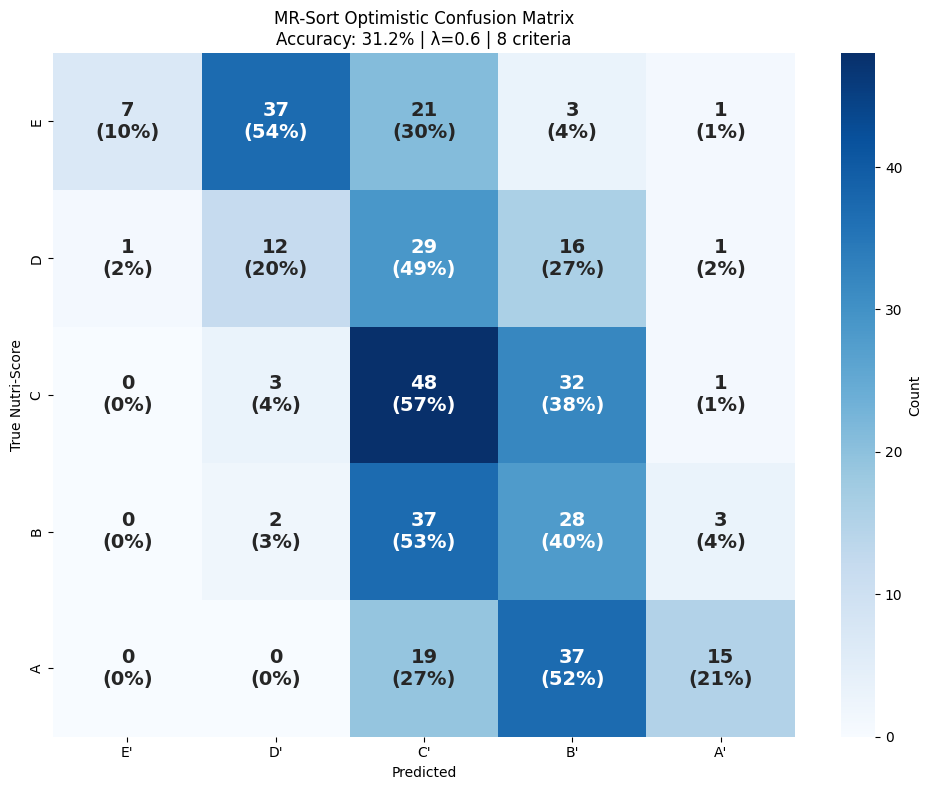


Per-category accuracy:
  E: 10.1% (69 samples)
  D: 20.3% (59 samples)
  C: 57.1% (84 samples)
  B: 40.0% (70 samples)
  A: 21.1% (71 samples)

              precision    recall  f1-score   support

           A       0.71      0.21      0.33        71
           B       0.24      0.40      0.30        70
           C       0.31      0.57      0.40        84
           D       0.22      0.20      0.21        59
           E       0.88      0.10      0.18        69

    accuracy                           0.31       353
   macro avg       0.47      0.30      0.28       353
weighted avg       0.47      0.31      0.29       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 31.2% (110/353)


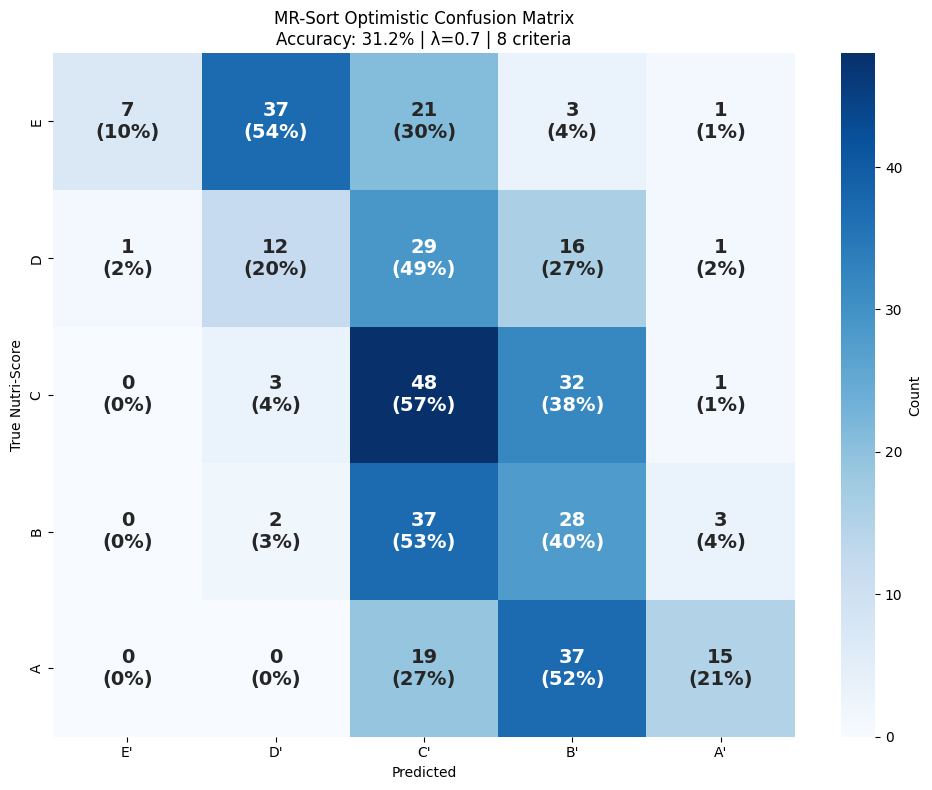


Per-category accuracy:
  E: 10.1% (69 samples)
  D: 20.3% (59 samples)
  C: 57.1% (84 samples)
  B: 40.0% (70 samples)
  A: 21.1% (71 samples)

              precision    recall  f1-score   support

           A       0.71      0.21      0.33        71
           B       0.24      0.40      0.30        70
           C       0.31      0.57      0.40        84
           D       0.22      0.20      0.21        59
           E       0.88      0.10      0.18        69

    accuracy                           0.31       353
   macro avg       0.47      0.30      0.28       353
weighted avg       0.47      0.31      0.29       353



In [29]:
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_distribution, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_distribution, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_distribution, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, None, profile_distribution, method='optimistic', lambda_threshold=0.7)

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 37.7% (133/353)


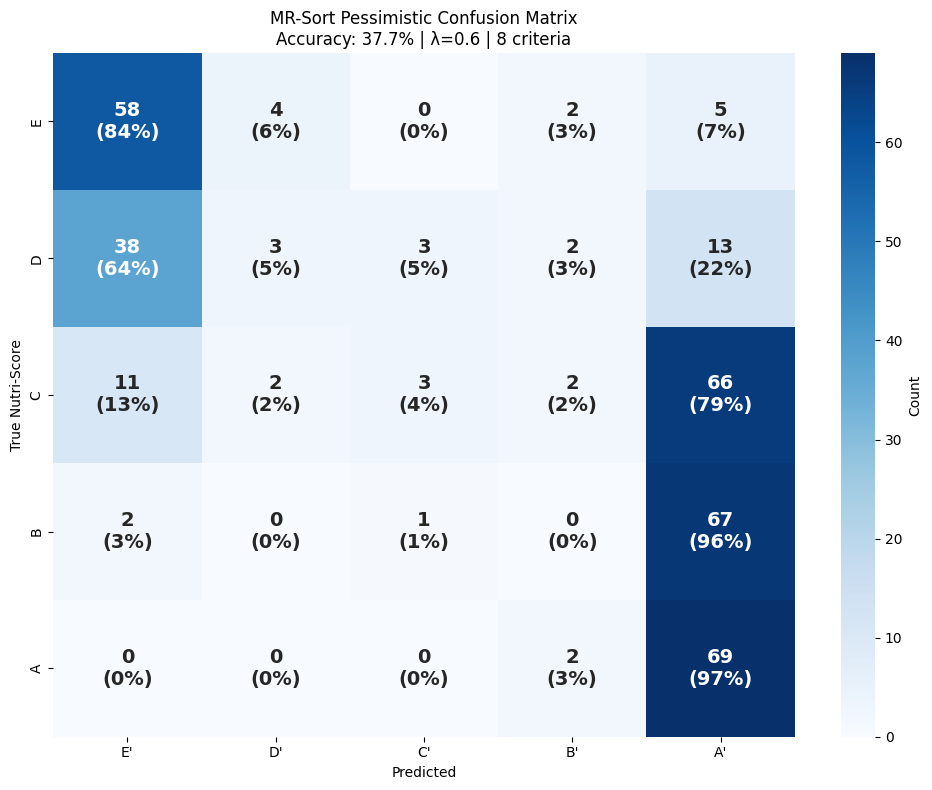


Per-category accuracy:
  E: 84.1% (69 samples)
  D: 5.1% (59 samples)
  C: 3.6% (84 samples)
  B: 0.0% (70 samples)
  A: 97.2% (71 samples)

              precision    recall  f1-score   support

           A       0.31      0.97      0.47        71
           B       0.00      0.00      0.00        70
           C       0.43      0.04      0.07        84
           D       0.33      0.05      0.09        59
           E       0.53      0.84      0.65        69

    accuracy                           0.38       353
   macro avg       0.32      0.38      0.26       353
weighted avg       0.32      0.38      0.25       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Pessimistic Results
Overall Accuracy: 38.0% (134/353)


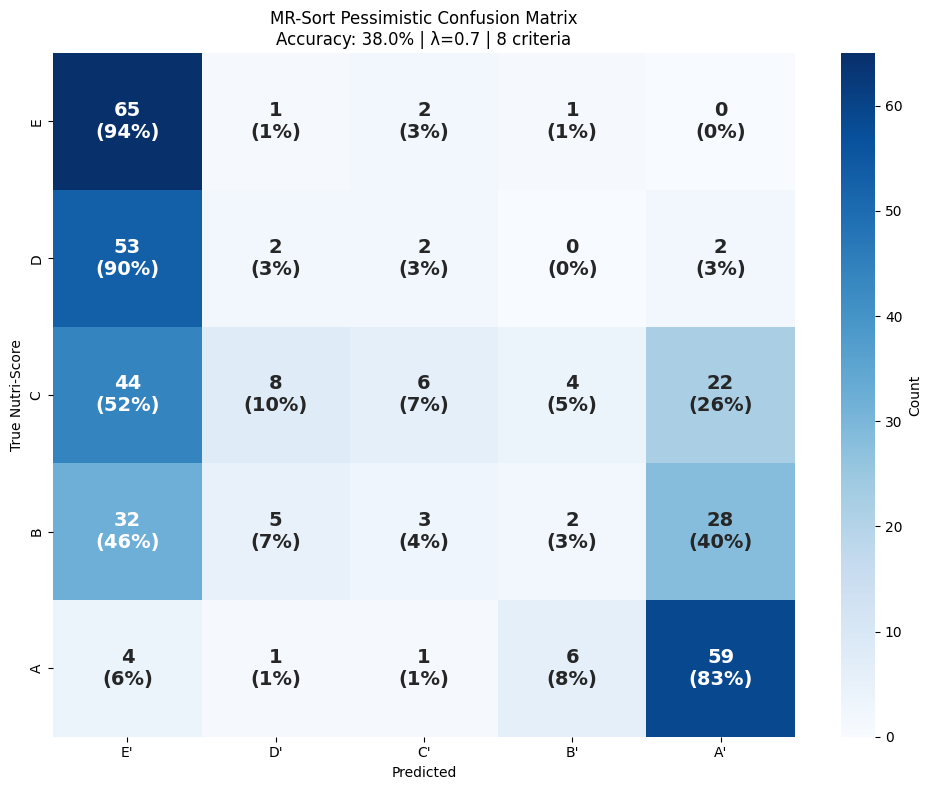


Per-category accuracy:
  E: 94.2% (69 samples)
  D: 3.4% (59 samples)
  C: 7.1% (84 samples)
  B: 2.9% (70 samples)
  A: 83.1% (71 samples)

              precision    recall  f1-score   support

           A       0.53      0.83      0.65        71
           B       0.15      0.03      0.05        70
           C       0.43      0.07      0.12        84
           D       0.12      0.03      0.05        59
           E       0.33      0.94      0.49        69

    accuracy                           0.38       353
   macro avg       0.31      0.38      0.27       353
weighted avg       0.32      0.38      0.27       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 31.7% (112/353)


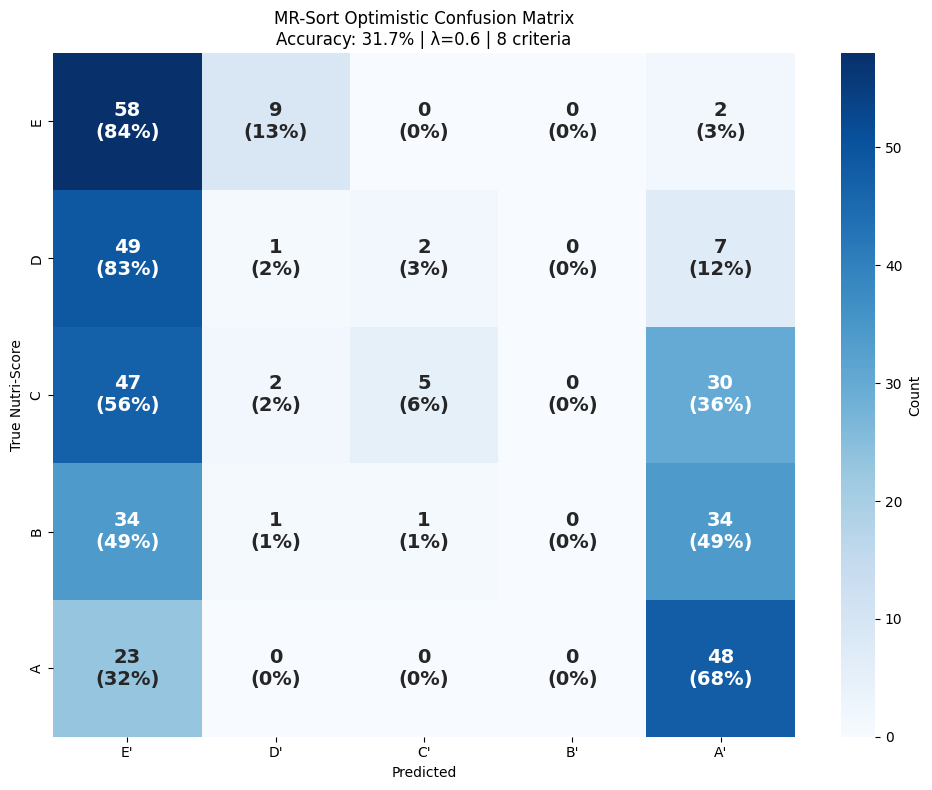


Per-category accuracy:
  E: 84.1% (69 samples)
  D: 1.7% (59 samples)
  C: 6.0% (84 samples)
  B: 0.0% (70 samples)
  A: 67.6% (71 samples)

              precision    recall  f1-score   support

           A       0.40      0.68      0.50        71
           B       0.00      0.00      0.00        70
           C       0.62      0.06      0.11        84
           D       0.08      0.02      0.03        59
           E       0.27      0.84      0.41        69

    accuracy                           0.32       353
   macro avg       0.27      0.32      0.21       353
weighted avg       0.30      0.32      0.21       353

✅ Using 8/8 criteria: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']

📊 MR-Sort Optimistic Results
Overall Accuracy: 30.6% (108/353)


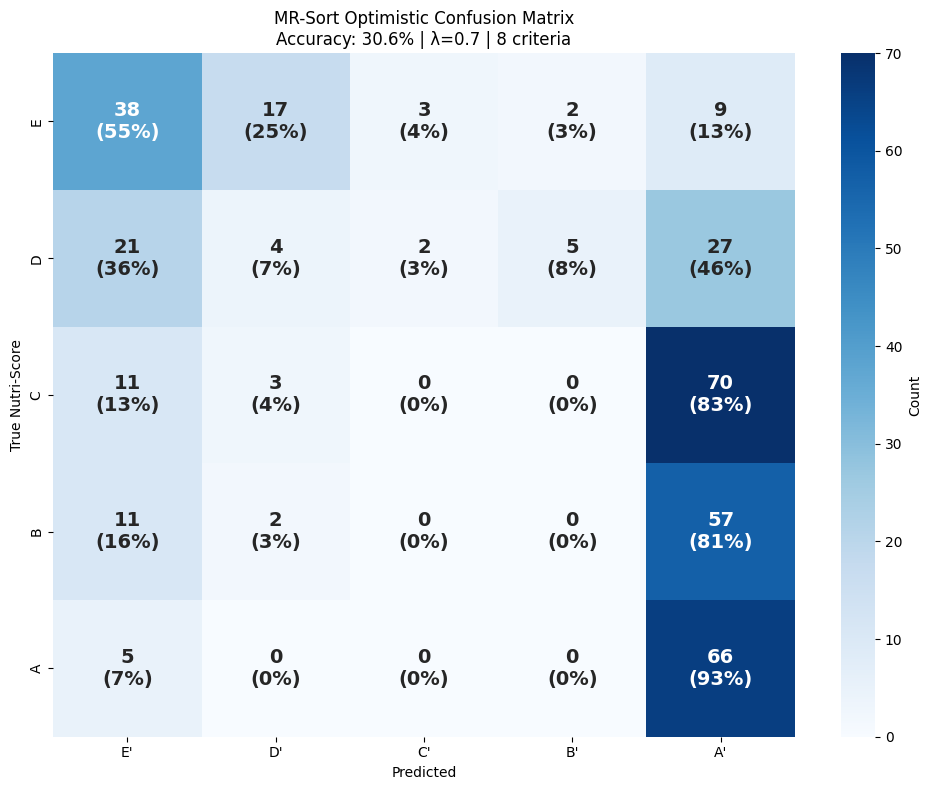


Per-category accuracy:
  E: 55.1% (69 samples)
  D: 6.8% (59 samples)
  C: 0.0% (84 samples)
  B: 0.0% (70 samples)
  A: 93.0% (71 samples)

              precision    recall  f1-score   support

           A       0.29      0.93      0.44        71
           B       0.00      0.00      0.00        70
           C       0.00      0.00      0.00        84
           D       0.15      0.07      0.09        59
           E       0.44      0.55      0.49        69

    accuracy                           0.31       353
   macro avg       0.18      0.31      0.20       353
weighted avg       0.17      0.31      0.20       353



In [30]:
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, None, method='pessimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, None, method='pessimistic', lambda_threshold=0.7)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, None, method='optimistic', lambda_threshold=0.6)
_, _, _, _ = mrsort_confusion_analysis(df, weight_correlation, None, method='optimistic', lambda_threshold=0.7)